In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

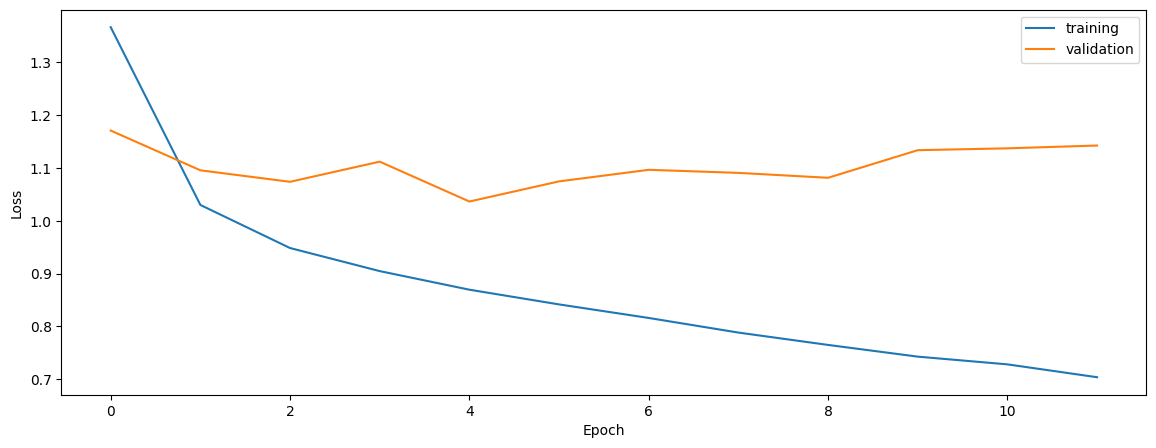

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/107 [..............................] - ETA: 2:06 - loss: 0.2471 - STD: 1.0792e-04 - MAE: 0.4832


  3/107 [..............................] - ETA: 32s - loss: 0.2314 - STD: 3.1499e-04 - MAE: 0.4431 


  6/107 [>.............................] - ETA: 13s - loss: 0.2287 - STD: 5.9289e-04 - MAE: 0.4363


  9/107 [=>............................] - ETA: 8s - loss: 0.2268 - STD: 9.6712e-04 - MAE: 0.4447 


 12/107 [==>...........................] - ETA: 6s - loss: 0.2250 - STD: 0.0013 - MAE: 0.4471    


 16/107 [===>..........................] - ETA: 5s - loss: 0.2235 - STD: 0.0017 - MAE: 0.4439


 20/107 [====>.........................] - ETA: 4s - loss: 0.2221 - STD: 0.0022 - MAE: 0.4427


 23/107 [=====>........................] - ETA: 3s - loss: 0.2213 - STD: 0.0027 - MAE: 0.4436


 26/107 [======>.......................] - ETA: 3s - loss: 0.2206 - STD: 0.0033 - MAE: 0.4437


 29/107 [=======>......................] - ETA: 2s - loss: 0.2200 - STD: 0.0041 - MAE: 0.4429


 32/107 [=======>......................] - ETA: 2s - loss: 0.2195 - STD: 0.0051 - MAE: 0.4423


 35/107 [========>.....................] - ETA: 2s - loss: 0.2189 - STD: 0.0067 - MAE: 0.4422


 39/107 [=========>....................] - ETA: 2s - loss: 0.2180 - STD: 0.0096 - MAE: 0.4417


 43/107 [===========>..................] - ETA: 1s - loss: 0.2169 - STD: 0.0140 - MAE: 0.4402


 47/107 [============>.................] - ETA: 1s - loss: 0.2155 - STD: 0.0205 - MAE: 0.4381


 51/107 [=============>................] - ETA: 1s - loss: 0.2142 - STD: 0.0277 - MAE: 0.4356


 55/107 [==============>...............] - ETA: 1s - loss: 0.2128 - STD: 0.0350 - MAE: 0.4332


 59/107 [===============>..............] - ETA: 1s - loss: 0.2116 - STD: 0.0414 - MAE: 0.4310


 62/107 [================>.............] - ETA: 1s - loss: 0.2108 - STD: 0.0463 - MAE: 0.4294


 66/107 [=================>............] - ETA: 1s - loss: 0.2097 - STD: 0.0525 - MAE: 0.4272


 70/107 [==================>...........] - ETA: 0s - loss: 0.2086 - STD: 0.0584 - MAE: 0.4251


 74/107 [===================>..........] - ETA: 0s - loss: 0.2077 - STD: 0.0635 - MAE: 0.4233


 78/107 [====================>.........] - ETA: 0s - loss: 0.2070 - STD: 0.0681 - MAE: 0.4218


 82/107 [=====================>........] - ETA: 0s - loss: 0.2062 - STD: 0.0723 - MAE: 0.4203


 86/107 [=======================>......] - ETA: 0s - loss: 0.2055 - STD: 0.0763 - MAE: 0.4188


 90/107 [========================>.....] - ETA: 0s - loss: 0.2048 - STD: 0.0801 - MAE: 0.4174


 94/107 [=========================>....] - ETA: 0s - loss: 0.2041 - STD: 0.0833 - MAE: 0.4162


 98/107 [==========================>...] - ETA: 0s - loss: 0.2036 - STD: 0.0861 - MAE: 0.4150


102/107 [===========================>..] - ETA: 0s - loss: 0.2030 - STD: 0.0890 - MAE: 0.4140


106/107 [============================>.] - ETA: 0s - loss: 0.2026 - STD: 0.0915 - MAE: 0.4131


107/107 [==============================] - 4s 27ms/step - loss: 0.2024 - STD: 0.0921 - MAE: 0.4128 - val_loss: 0.1874 - val_STD: 0.1235 - val_MAE: 0.3893


Epoch 2/10000



  1/107 [..............................] - ETA: 6s - loss: 0.1892 - STD: 0.1533 - MAE: 0.3882


  4/107 [>.............................] - ETA: 2s - loss: 0.1890 - STD: 0.1583 - MAE: 0.3876


  7/107 [>.............................] - ETA: 1s - loss: 0.1883 - STD: 0.1588 - MAE: 0.3860


 10/107 [=>............................] - ETA: 1s - loss: 0.1886 - STD: 0.1596 - MAE: 0.3862


 13/107 [==>...........................] - ETA: 1s - loss: 0.1885 - STD: 0.1582 - MAE: 0.3864


 17/107 [===>..........................] - ETA: 1s - loss: 0.1880 - STD: 0.1590 - MAE: 0.3858


 21/107 [====>.........................] - ETA: 1s - loss: 0.1878 - STD: 0.1592 - MAE: 0.3854


 25/107 [======>.......................] - ETA: 1s - loss: 0.1875 - STD: 0.1599 - MAE: 0.3849


 29/107 [=======>......................] - ETA: 1s - loss: 0.1870 - STD: 0.1621 - MAE: 0.3837


 33/107 [========>.....................] - ETA: 1s - loss: 0.1862 - STD: 0.1637 - MAE: 0.3826


 37/107 [=========>....................] - ETA: 1s - loss: 0.1853 - STD: 0.1663 - MAE: 0.3809


 40/107 [==========>...................] - ETA: 1s - loss: 0.1849 - STD: 0.1686 - MAE: 0.3798


 44/107 [===========>..................] - ETA: 1s - loss: 0.1843 - STD: 0.1709 - MAE: 0.3786


 48/107 [============>.................] - ETA: 0s - loss: 0.1839 - STD: 0.1724 - MAE: 0.3776


 52/107 [=============>................] - ETA: 0s - loss: 0.1834 - STD: 0.1738 - MAE: 0.3767


 56/107 [==============>...............] - ETA: 0s - loss: 0.1831 - STD: 0.1749 - MAE: 0.3760


 60/107 [===============>..............] - ETA: 0s - loss: 0.1827 - STD: 0.1756 - MAE: 0.3755


 64/107 [================>.............] - ETA: 0s - loss: 0.1823 - STD: 0.1766 - MAE: 0.3747


 67/107 [=================>............] - ETA: 0s - loss: 0.1819 - STD: 0.1776 - MAE: 0.3740


 71/107 [==================>...........] - ETA: 0s - loss: 0.1816 - STD: 0.1790 - MAE: 0.3734


 75/107 [====================>.........] - ETA: 0s - loss: 0.1812 - STD: 0.1804 - MAE: 0.3726


 78/107 [====================>.........] - ETA: 0s - loss: 0.1810 - STD: 0.1813 - MAE: 0.3721


 82/107 [=====================>........] - ETA: 0s - loss: 0.1807 - STD: 0.1824 - MAE: 0.3715


 86/107 [=======================>......] - ETA: 0s - loss: 0.1804 - STD: 0.1833 - MAE: 0.3709


 90/107 [========================>.....] - ETA: 0s - loss: 0.1800 - STD: 0.1841 - MAE: 0.3703


 94/107 [=========================>....] - ETA: 0s - loss: 0.1797 - STD: 0.1848 - MAE: 0.3698


 98/107 [==========================>...] - ETA: 0s - loss: 0.1795 - STD: 0.1855 - MAE: 0.3693


102/107 [===========================>..] - ETA: 0s - loss: 0.1792 - STD: 0.1863 - MAE: 0.3688


106/107 [============================>.] - ETA: 0s - loss: 0.1789 - STD: 0.1872 - MAE: 0.3682


107/107 [==============================] - 2s 18ms/step - loss: 0.1788 - STD: 0.1875 - MAE: 0.3680 - val_loss: 0.1678 - val_STD: 0.1813 - val_MAE: 0.3503


Epoch 3/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1730 - STD: 0.2135 - MAE: 0.3561


  5/107 [>.............................] - ETA: 1s - loss: 0.1722 - STD: 0.2094 - MAE: 0.3549


  9/107 [=>............................] - ETA: 1s - loss: 0.1711 - STD: 0.2076 - MAE: 0.3542


 13/107 [==>...........................] - ETA: 1s - loss: 0.1712 - STD: 0.2085 - MAE: 0.3541


 17/107 [===>..........................] - ETA: 1s - loss: 0.1710 - STD: 0.2087 - MAE: 0.3536


 21/107 [====>.........................] - ETA: 1s - loss: 0.1714 - STD: 0.2087 - MAE: 0.3541


 25/107 [======>.......................] - ETA: 1s - loss: 0.1727 - STD: 0.2077 - MAE: 0.3545


 29/107 [=======>......................] - ETA: 1s - loss: 0.1736 - STD: 0.2064 - MAE: 0.3554


 33/107 [========>.....................] - ETA: 1s - loss: 0.1742 - STD: 0.2042 - MAE: 0.3567


 37/107 [=========>....................] - ETA: 1s - loss: 0.1742 - STD: 0.2018 - MAE: 0.3575


 41/107 [==========>...................] - ETA: 1s - loss: 0.1743 - STD: 0.2008 - MAE: 0.3578


 45/107 [===========>..................] - ETA: 0s - loss: 0.1740 - STD: 0.2015 - MAE: 0.3575


 49/107 [============>.................] - ETA: 0s - loss: 0.1738 - STD: 0.2023 - MAE: 0.3572


 53/107 [=============>................] - ETA: 0s - loss: 0.1738 - STD: 0.2031 - MAE: 0.3569


 57/107 [==============>...............] - ETA: 0s - loss: 0.1735 - STD: 0.2037 - MAE: 0.3566


 61/107 [================>.............] - ETA: 0s - loss: 0.1734 - STD: 0.2042 - MAE: 0.3564


 65/107 [=================>............] - ETA: 0s - loss: 0.1732 - STD: 0.2047 - MAE: 0.3560


 69/107 [==================>...........] - ETA: 0s - loss: 0.1730 - STD: 0.2049 - MAE: 0.3557


 73/107 [===================>..........] - ETA: 0s - loss: 0.1728 - STD: 0.2051 - MAE: 0.3556


 77/107 [====================>.........] - ETA: 0s - loss: 0.1726 - STD: 0.2054 - MAE: 0.3554


 81/107 [=====================>........] - ETA: 0s - loss: 0.1724 - STD: 0.2059 - MAE: 0.3550


 85/107 [======================>.......] - ETA: 0s - loss: 0.1722 - STD: 0.2064 - MAE: 0.3547


 89/107 [=======================>......] - ETA: 0s - loss: 0.1721 - STD: 0.2068 - MAE: 0.3545


 93/107 [=========================>....] - ETA: 0s - loss: 0.1720 - STD: 0.2071 - MAE: 0.3543


 97/107 [==========================>...] - ETA: 0s - loss: 0.1719 - STD: 0.2074 - MAE: 0.3540


101/107 [===========================>..] - ETA: 0s - loss: 0.1718 - STD: 0.2078 - MAE: 0.3538


105/107 [============================>.] - ETA: 0s - loss: 0.1716 - STD: 0.2080 - MAE: 0.3536


107/107 [==============================] - 2s 17ms/step - loss: 0.1715 - STD: 0.2081 - MAE: 0.3535 - val_loss: 0.1646 - val_STD: 0.1766 - val_MAE: 0.3421


Epoch 4/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1694 - STD: 0.2093 - MAE: 0.3476


  5/107 [>.............................] - ETA: 1s - loss: 0.1683 - STD: 0.2142 - MAE: 0.3492


  9/107 [=>............................] - ETA: 1s - loss: 0.1679 - STD: 0.2163 - MAE: 0.3485


 13/107 [==>...........................] - ETA: 1s - loss: 0.1678 - STD: 0.2182 - MAE: 0.3479


 17/107 [===>..........................] - ETA: 1s - loss: 0.1674 - STD: 0.2195 - MAE: 0.3469


 21/107 [====>.........................] - ETA: 1s - loss: 0.1672 - STD: 0.2197 - MAE: 0.3464


 25/107 [======>.......................] - ETA: 1s - loss: 0.1670 - STD: 0.2197 - MAE: 0.3462


 29/107 [=======>......................] - ETA: 1s - loss: 0.1669 - STD: 0.2203 - MAE: 0.3460


 33/107 [========>.....................] - ETA: 1s - loss: 0.1668 - STD: 0.2202 - MAE: 0.3459


 37/107 [=========>....................] - ETA: 1s - loss: 0.1667 - STD: 0.2204 - MAE: 0.3458


 41/107 [==========>...................] - ETA: 1s - loss: 0.1665 - STD: 0.2208 - MAE: 0.3453


 45/107 [===========>..................] - ETA: 0s - loss: 0.1663 - STD: 0.2214 - MAE: 0.3450


 49/107 [============>.................] - ETA: 0s - loss: 0.1661 - STD: 0.2216 - MAE: 0.3446


 53/107 [=============>................] - ETA: 0s - loss: 0.1660 - STD: 0.2220 - MAE: 0.3445


 57/107 [==============>...............] - ETA: 0s - loss: 0.1665 - STD: 0.2219 - MAE: 0.3445


 61/107 [================>.............] - ETA: 0s - loss: 0.1666 - STD: 0.2214 - MAE: 0.3447


 65/107 [=================>............] - ETA: 0s - loss: 0.1672 - STD: 0.2206 - MAE: 0.3452


 69/107 [==================>...........] - ETA: 0s - loss: 0.1674 - STD: 0.2200 - MAE: 0.3455


 73/107 [===================>..........] - ETA: 0s - loss: 0.1675 - STD: 0.2186 - MAE: 0.3458


 77/107 [====================>.........] - ETA: 0s - loss: 0.1676 - STD: 0.2177 - MAE: 0.3463


 81/107 [=====================>........] - ETA: 0s - loss: 0.1676 - STD: 0.2176 - MAE: 0.3462


 85/107 [======================>.......] - ETA: 0s - loss: 0.1676 - STD: 0.2177 - MAE: 0.3462


 89/107 [=======================>......] - ETA: 0s - loss: 0.1675 - STD: 0.2178 - MAE: 0.3461


 93/107 [=========================>....] - ETA: 0s - loss: 0.1674 - STD: 0.2182 - MAE: 0.3459


 97/107 [==========================>...] - ETA: 0s - loss: 0.1673 - STD: 0.2185 - MAE: 0.3456


101/107 [===========================>..] - ETA: 0s - loss: 0.1671 - STD: 0.2187 - MAE: 0.3454


105/107 [============================>.] - ETA: 0s - loss: 0.1670 - STD: 0.2189 - MAE: 0.3452


107/107 [==============================] - 2s 18ms/step - loss: 0.1669 - STD: 0.2191 - MAE: 0.3451 - val_loss: 0.1597 - val_STD: 0.1950 - val_MAE: 0.3347


Epoch 5/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1633 - STD: 0.2265 - MAE: 0.3376


  5/107 [>.............................] - ETA: 1s - loss: 0.1642 - STD: 0.2281 - MAE: 0.3388


  9/107 [=>............................] - ETA: 1s - loss: 0.1645 - STD: 0.2264 - MAE: 0.3396


 13/107 [==>...........................] - ETA: 1s - loss: 0.1644 - STD: 0.2268 - MAE: 0.3398


 17/107 [===>..........................] - ETA: 1s - loss: 0.1638 - STD: 0.2274 - MAE: 0.3393


 21/107 [====>.........................] - ETA: 1s - loss: 0.1634 - STD: 0.2272 - MAE: 0.3391


 25/107 [======>.......................] - ETA: 1s - loss: 0.1632 - STD: 0.2279 - MAE: 0.3387


 29/107 [=======>......................] - ETA: 1s - loss: 0.1633 - STD: 0.2284 - MAE: 0.3386


 33/107 [========>.....................] - ETA: 1s - loss: 0.1633 - STD: 0.2284 - MAE: 0.3387


 37/107 [=========>....................] - ETA: 1s - loss: 0.1632 - STD: 0.2286 - MAE: 0.3385


 41/107 [==========>...................] - ETA: 1s - loss: 0.1630 - STD: 0.2286 - MAE: 0.3384


 45/107 [===========>..................] - ETA: 0s - loss: 0.1629 - STD: 0.2289 - MAE: 0.3382


 49/107 [============>.................] - ETA: 0s - loss: 0.1629 - STD: 0.2291 - MAE: 0.3380


 53/107 [=============>................] - ETA: 0s - loss: 0.1633 - STD: 0.2290 - MAE: 0.3380


 57/107 [==============>...............] - ETA: 0s - loss: 0.1640 - STD: 0.2286 - MAE: 0.3386


 61/107 [================>.............] - ETA: 0s - loss: 0.1641 - STD: 0.2277 - MAE: 0.3390


 65/107 [=================>............] - ETA: 0s - loss: 0.1642 - STD: 0.2264 - MAE: 0.3396


 69/107 [==================>...........] - ETA: 0s - loss: 0.1642 - STD: 0.2259 - MAE: 0.3397


 73/107 [===================>..........] - ETA: 0s - loss: 0.1642 - STD: 0.2257 - MAE: 0.3397


 77/107 [====================>.........] - ETA: 0s - loss: 0.1641 - STD: 0.2257 - MAE: 0.3397


 81/107 [=====================>........] - ETA: 0s - loss: 0.1640 - STD: 0.2260 - MAE: 0.3395


 85/107 [======================>.......] - ETA: 0s - loss: 0.1640 - STD: 0.2264 - MAE: 0.3393


 89/107 [=======================>......] - ETA: 0s - loss: 0.1638 - STD: 0.2266 - MAE: 0.3392


 93/107 [=========================>....] - ETA: 0s - loss: 0.1638 - STD: 0.2268 - MAE: 0.3392


 97/107 [==========================>...] - ETA: 0s - loss: 0.1637 - STD: 0.2270 - MAE: 0.3391


101/107 [===========================>..] - ETA: 0s - loss: 0.1636 - STD: 0.2272 - MAE: 0.3389


105/107 [============================>.] - ETA: 0s - loss: 0.1635 - STD: 0.2274 - MAE: 0.3387


107/107 [==============================] - 2s 17ms/step - loss: 0.1634 - STD: 0.2276 - MAE: 0.3386 - val_loss: 0.1578 - val_STD: 0.2094 - val_MAE: 0.3321


Epoch 6/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1620 - STD: 0.2382 - MAE: 0.3358


  4/107 [>.............................] - ETA: 1s - loss: 0.1611 - STD: 0.2388 - MAE: 0.3329


  8/107 [=>............................] - ETA: 1s - loss: 0.1608 - STD: 0.2390 - MAE: 0.3325


 12/107 [==>...........................] - ETA: 1s - loss: 0.1607 - STD: 0.2375 - MAE: 0.3324


 16/107 [===>..........................] - ETA: 1s - loss: 0.1609 - STD: 0.2367 - MAE: 0.3327


 20/107 [====>.........................] - ETA: 1s - loss: 0.1616 - STD: 0.2362 - MAE: 0.3338


 24/107 [=====>........................] - ETA: 1s - loss: 0.1617 - STD: 0.2344 - MAE: 0.3344


 28/107 [======>.......................] - ETA: 1s - loss: 0.1614 - STD: 0.2336 - MAE: 0.3345


 32/107 [=======>......................] - ETA: 1s - loss: 0.1613 - STD: 0.2337 - MAE: 0.3345


 36/107 [=========>....................] - ETA: 1s - loss: 0.1612 - STD: 0.2338 - MAE: 0.3344


 40/107 [==========>...................] - ETA: 1s - loss: 0.1611 - STD: 0.2341 - MAE: 0.3343


 44/107 [===========>..................] - ETA: 0s - loss: 0.1611 - STD: 0.2340 - MAE: 0.3341


 48/107 [============>.................] - ETA: 0s - loss: 0.1610 - STD: 0.2345 - MAE: 0.3339


 52/107 [=============>................] - ETA: 0s - loss: 0.1609 - STD: 0.2346 - MAE: 0.3338


 56/107 [==============>...............] - ETA: 0s - loss: 0.1609 - STD: 0.2348 - MAE: 0.3338


 60/107 [===============>..............] - ETA: 0s - loss: 0.1607 - STD: 0.2347 - MAE: 0.3337


 64/107 [================>.............] - ETA: 0s - loss: 0.1607 - STD: 0.2347 - MAE: 0.3336


 68/107 [==================>...........] - ETA: 0s - loss: 0.1606 - STD: 0.2348 - MAE: 0.3335


 72/107 [===================>..........] - ETA: 0s - loss: 0.1605 - STD: 0.2349 - MAE: 0.3335


 76/107 [====================>.........] - ETA: 0s - loss: 0.1605 - STD: 0.2350 - MAE: 0.3334


 80/107 [=====================>........] - ETA: 0s - loss: 0.1604 - STD: 0.2351 - MAE: 0.3333


 84/107 [======================>.......] - ETA: 0s - loss: 0.1604 - STD: 0.2354 - MAE: 0.3331


 88/107 [=======================>......] - ETA: 0s - loss: 0.1605 - STD: 0.2355 - MAE: 0.3331


 92/107 [========================>.....] - ETA: 0s - loss: 0.1607 - STD: 0.2353 - MAE: 0.3332


 96/107 [=========================>....] - ETA: 0s - loss: 0.1611 - STD: 0.2347 - MAE: 0.3334


100/107 [===========================>..] - ETA: 0s - loss: 0.1613 - STD: 0.2343 - MAE: 0.3337


104/107 [============================>.] - ETA: 0s - loss: 0.1614 - STD: 0.2335 - MAE: 0.3341


107/107 [==============================] - 2s 17ms/step - loss: 0.1614 - STD: 0.2330 - MAE: 0.3343 - val_loss: 0.1575 - val_STD: 0.1839 - val_MAE: 0.3350


Epoch 7/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1599 - STD: 0.2157 - MAE: 0.3367


  5/107 [>.............................] - ETA: 1s - loss: 0.1598 - STD: 0.2263 - MAE: 0.3346


  9/107 [=>............................] - ETA: 1s - loss: 0.1600 - STD: 0.2317 - MAE: 0.3332


 13/107 [==>...........................] - ETA: 1s - loss: 0.1597 - STD: 0.2348 - MAE: 0.3321


 17/107 [===>..........................] - ETA: 1s - loss: 0.1593 - STD: 0.2368 - MAE: 0.3312


 21/107 [====>.........................] - ETA: 1s - loss: 0.1593 - STD: 0.2371 - MAE: 0.3309


 25/107 [======>.......................] - ETA: 1s - loss: 0.1592 - STD: 0.2375 - MAE: 0.3309


 29/107 [=======>......................] - ETA: 1s - loss: 0.1590 - STD: 0.2377 - MAE: 0.3306


 33/107 [========>.....................] - ETA: 1s - loss: 0.1590 - STD: 0.2375 - MAE: 0.3307


 37/107 [=========>....................] - ETA: 1s - loss: 0.1589 - STD: 0.2379 - MAE: 0.3307


 41/107 [==========>...................] - ETA: 1s - loss: 0.1589 - STD: 0.2383 - MAE: 0.3304


 45/107 [===========>..................] - ETA: 0s - loss: 0.1588 - STD: 0.2386 - MAE: 0.3301


 49/107 [============>.................] - ETA: 0s - loss: 0.1589 - STD: 0.2388 - MAE: 0.3302


 53/107 [=============>................] - ETA: 0s - loss: 0.1591 - STD: 0.2385 - MAE: 0.3302


 57/107 [==============>...............] - ETA: 0s - loss: 0.1593 - STD: 0.2381 - MAE: 0.3304


 61/107 [================>.............] - ETA: 0s - loss: 0.1594 - STD: 0.2378 - MAE: 0.3308


 65/107 [=================>............] - ETA: 0s - loss: 0.1597 - STD: 0.2375 - MAE: 0.3311


 69/107 [==================>...........] - ETA: 0s - loss: 0.1596 - STD: 0.2370 - MAE: 0.3313


 73/107 [===================>..........] - ETA: 0s - loss: 0.1596 - STD: 0.2368 - MAE: 0.3313


 77/107 [====================>.........] - ETA: 0s - loss: 0.1594 - STD: 0.2368 - MAE: 0.3312


 81/107 [=====================>........] - ETA: 0s - loss: 0.1594 - STD: 0.2371 - MAE: 0.3310


 85/107 [======================>.......] - ETA: 0s - loss: 0.1593 - STD: 0.2374 - MAE: 0.3309


 89/107 [=======================>......] - ETA: 0s - loss: 0.1592 - STD: 0.2377 - MAE: 0.3307


 93/107 [=========================>....] - ETA: 0s - loss: 0.1591 - STD: 0.2379 - MAE: 0.3306


 97/107 [==========================>...] - ETA: 0s - loss: 0.1591 - STD: 0.2381 - MAE: 0.3305


101/107 [===========================>..] - ETA: 0s - loss: 0.1590 - STD: 0.2382 - MAE: 0.3303


105/107 [============================>.] - ETA: 0s - loss: 0.1591 - STD: 0.2381 - MAE: 0.3304


107/107 [==============================] - 2s 17ms/step - loss: 0.1590 - STD: 0.2383 - MAE: 0.3303 - val_loss: 0.1556 - val_STD: 0.2034 - val_MAE: 0.3235


Epoch 8/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1590 - STD: 0.2399 - MAE: 0.3277


  5/107 [>.............................] - ETA: 1s - loss: 0.1590 - STD: 0.2426 - MAE: 0.3294


  9/107 [=>............................] - ETA: 1s - loss: 0.1587 - STD: 0.2404 - MAE: 0.3294


 13/107 [==>...........................] - ETA: 1s - loss: 0.1582 - STD: 0.2406 - MAE: 0.3286


 17/107 [===>..........................] - ETA: 1s - loss: 0.1582 - STD: 0.2402 - MAE: 0.3286


 21/107 [====>.........................] - ETA: 1s - loss: 0.1582 - STD: 0.2411 - MAE: 0.3285


 25/107 [======>.......................] - ETA: 1s - loss: 0.1581 - STD: 0.2407 - MAE: 0.3284


 29/107 [=======>......................] - ETA: 1s - loss: 0.1580 - STD: 0.2408 - MAE: 0.3282


 33/107 [========>.....................] - ETA: 1s - loss: 0.1580 - STD: 0.2411 - MAE: 0.3282


 37/107 [=========>....................] - ETA: 1s - loss: 0.1579 - STD: 0.2407 - MAE: 0.3282


 41/107 [==========>...................] - ETA: 1s - loss: 0.1580 - STD: 0.2408 - MAE: 0.3282


 45/107 [===========>..................] - ETA: 0s - loss: 0.1581 - STD: 0.2406 - MAE: 0.3285


 49/107 [============>.................] - ETA: 0s - loss: 0.1580 - STD: 0.2408 - MAE: 0.3282


 53/107 [=============>................] - ETA: 0s - loss: 0.1579 - STD: 0.2409 - MAE: 0.3281


 57/107 [==============>...............] - ETA: 0s - loss: 0.1579 - STD: 0.2410 - MAE: 0.3281


 61/107 [================>.............] - ETA: 0s - loss: 0.1576 - STD: 0.2413 - MAE: 0.3278


 65/107 [=================>............] - ETA: 0s - loss: 0.1575 - STD: 0.2417 - MAE: 0.3275


 69/107 [==================>...........] - ETA: 0s - loss: 0.1574 - STD: 0.2419 - MAE: 0.3273


 73/107 [===================>..........] - ETA: 0s - loss: 0.1573 - STD: 0.2422 - MAE: 0.3271


 77/107 [====================>.........] - ETA: 0s - loss: 0.1575 - STD: 0.2422 - MAE: 0.3271


 81/107 [=====================>........] - ETA: 0s - loss: 0.1575 - STD: 0.2421 - MAE: 0.3271


 85/107 [======================>.......] - ETA: 0s - loss: 0.1581 - STD: 0.2420 - MAE: 0.3275


 89/107 [=======================>......] - ETA: 0s - loss: 0.1583 - STD: 0.2413 - MAE: 0.3278


 93/107 [=========================>....] - ETA: 0s - loss: 0.1585 - STD: 0.2404 - MAE: 0.3283


 97/107 [==========================>...] - ETA: 0s - loss: 0.1587 - STD: 0.2397 - MAE: 0.3287


101/107 [===========================>..] - ETA: 0s - loss: 0.1587 - STD: 0.2391 - MAE: 0.3289


105/107 [============================>.] - ETA: 0s - loss: 0.1587 - STD: 0.2387 - MAE: 0.3291


107/107 [==============================] - 2s 17ms/step - loss: 0.1588 - STD: 0.2386 - MAE: 0.3291 - val_loss: 0.1546 - val_STD: 0.2089 - val_MAE: 0.3276


Epoch 9/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1575 - STD: 0.2450 - MAE: 0.3278


  5/107 [>.............................] - ETA: 1s - loss: 0.1588 - STD: 0.2419 - MAE: 0.3296


  9/107 [=>............................] - ETA: 1s - loss: 0.1581 - STD: 0.2426 - MAE: 0.3280


 13/107 [==>...........................] - ETA: 1s - loss: 0.1573 - STD: 0.2428 - MAE: 0.3269


 17/107 [===>..........................] - ETA: 1s - loss: 0.1578 - STD: 0.2419 - MAE: 0.3276


 21/107 [====>.........................] - ETA: 1s - loss: 0.1578 - STD: 0.2421 - MAE: 0.3276


 25/107 [======>.......................] - ETA: 1s - loss: 0.1575 - STD: 0.2418 - MAE: 0.3274


 29/107 [=======>......................] - ETA: 1s - loss: 0.1572 - STD: 0.2419 - MAE: 0.3272


 33/107 [========>.....................] - ETA: 1s - loss: 0.1571 - STD: 0.2424 - MAE: 0.3268


 37/107 [=========>....................] - ETA: 1s - loss: 0.1569 - STD: 0.2427 - MAE: 0.3266


 41/107 [==========>...................] - ETA: 1s - loss: 0.1567 - STD: 0.2432 - MAE: 0.3262


 45/107 [===========>..................] - ETA: 0s - loss: 0.1567 - STD: 0.2440 - MAE: 0.3260


 49/107 [============>.................] - ETA: 0s - loss: 0.1569 - STD: 0.2439 - MAE: 0.3261


 53/107 [=============>................] - ETA: 0s - loss: 0.1570 - STD: 0.2439 - MAE: 0.3261


 57/107 [==============>...............] - ETA: 0s - loss: 0.1576 - STD: 0.2438 - MAE: 0.3265


 61/107 [================>.............] - ETA: 0s - loss: 0.1575 - STD: 0.2432 - MAE: 0.3266


 65/107 [=================>............] - ETA: 0s - loss: 0.1576 - STD: 0.2427 - MAE: 0.3269


 69/107 [==================>...........] - ETA: 0s - loss: 0.1576 - STD: 0.2421 - MAE: 0.3270


 73/107 [===================>..........] - ETA: 0s - loss: 0.1576 - STD: 0.2418 - MAE: 0.3271


 77/107 [====================>.........] - ETA: 0s - loss: 0.1575 - STD: 0.2418 - MAE: 0.3270


 81/107 [=====================>........] - ETA: 0s - loss: 0.1573 - STD: 0.2418 - MAE: 0.3268


 85/107 [======================>.......] - ETA: 0s - loss: 0.1572 - STD: 0.2421 - MAE: 0.3266


 89/107 [=======================>......] - ETA: 0s - loss: 0.1570 - STD: 0.2425 - MAE: 0.3263


 93/107 [=========================>....] - ETA: 0s - loss: 0.1569 - STD: 0.2429 - MAE: 0.3261


 97/107 [==========================>...] - ETA: 0s - loss: 0.1568 - STD: 0.2432 - MAE: 0.3259


101/107 [===========================>..] - ETA: 0s - loss: 0.1567 - STD: 0.2434 - MAE: 0.3257


105/107 [============================>.] - ETA: 0s - loss: 0.1566 - STD: 0.2437 - MAE: 0.3256


107/107 [==============================] - 2s 17ms/step - loss: 0.1566 - STD: 0.2437 - MAE: 0.3254 - val_loss: 0.1571 - val_STD: 0.2243 - val_MAE: 0.3277


Epoch 10/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1574 - STD: 0.2562 - MAE: 0.3260


  5/107 [>.............................] - ETA: 1s - loss: 0.1569 - STD: 0.2460 - MAE: 0.3242


  9/107 [=>............................] - ETA: 1s - loss: 0.1561 - STD: 0.2453 - MAE: 0.3233


 13/107 [==>...........................] - ETA: 1s - loss: 0.1562 - STD: 0.2463 - MAE: 0.3238


 17/107 [===>..........................] - ETA: 1s - loss: 0.1560 - STD: 0.2454 - MAE: 0.3241


 21/107 [====>.........................] - ETA: 1s - loss: 0.1562 - STD: 0.2451 - MAE: 0.3242


 25/107 [======>.......................] - ETA: 1s - loss: 0.1568 - STD: 0.2444 - MAE: 0.3246


 29/107 [=======>......................] - ETA: 1s - loss: 0.1573 - STD: 0.2443 - MAE: 0.3250


 33/107 [========>.....................] - ETA: 1s - loss: 0.1578 - STD: 0.2434 - MAE: 0.3258


 37/107 [=========>....................] - ETA: 1s - loss: 0.1578 - STD: 0.2427 - MAE: 0.3261


 41/107 [==========>...................] - ETA: 1s - loss: 0.1576 - STD: 0.2422 - MAE: 0.3262


 45/107 [===========>..................] - ETA: 0s - loss: 0.1576 - STD: 0.2417 - MAE: 0.3264


 49/107 [============>.................] - ETA: 0s - loss: 0.1577 - STD: 0.2417 - MAE: 0.3265


 53/107 [=============>................] - ETA: 0s - loss: 0.1574 - STD: 0.2418 - MAE: 0.3263


 57/107 [==============>...............] - ETA: 0s - loss: 0.1573 - STD: 0.2419 - MAE: 0.3261


 61/107 [================>.............] - ETA: 0s - loss: 0.1572 - STD: 0.2424 - MAE: 0.3258


 65/107 [=================>............] - ETA: 0s - loss: 0.1570 - STD: 0.2427 - MAE: 0.3257


 69/107 [==================>...........] - ETA: 0s - loss: 0.1568 - STD: 0.2431 - MAE: 0.3254


 73/107 [===================>..........] - ETA: 0s - loss: 0.1566 - STD: 0.2433 - MAE: 0.3252


 77/107 [====================>.........] - ETA: 0s - loss: 0.1564 - STD: 0.2437 - MAE: 0.3249


 81/107 [=====================>........] - ETA: 0s - loss: 0.1564 - STD: 0.2440 - MAE: 0.3246


 85/107 [======================>.......] - ETA: 0s - loss: 0.1563 - STD: 0.2443 - MAE: 0.3244


 89/107 [=======================>......] - ETA: 0s - loss: 0.1564 - STD: 0.2444 - MAE: 0.3244


 93/107 [=========================>....] - ETA: 0s - loss: 0.1563 - STD: 0.2446 - MAE: 0.3243


 97/107 [==========================>...] - ETA: 0s - loss: 0.1562 - STD: 0.2444 - MAE: 0.3243


101/107 [===========================>..] - ETA: 0s - loss: 0.1561 - STD: 0.2445 - MAE: 0.3242


105/107 [============================>.] - ETA: 0s - loss: 0.1560 - STD: 0.2446 - MAE: 0.3241


107/107 [==============================] - 2s 18ms/step - loss: 0.1560 - STD: 0.2446 - MAE: 0.3241 - val_loss: 0.1529 - val_STD: 0.2198 - val_MAE: 0.3211


Epoch 11/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1517 - STD: 0.2558 - MAE: 0.3169


  5/107 [>.............................] - ETA: 1s - loss: 0.1540 - STD: 0.2538 - MAE: 0.3190


  9/107 [=>............................] - ETA: 1s - loss: 0.1527 - STD: 0.2518 - MAE: 0.3184


 13/107 [==>...........................] - ETA: 1s - loss: 0.1529 - STD: 0.2525 - MAE: 0.3187


 17/107 [===>..........................] - ETA: 1s - loss: 0.1533 - STD: 0.2519 - MAE: 0.3192


 21/107 [====>.........................] - ETA: 1s - loss: 0.1535 - STD: 0.2515 - MAE: 0.3194


 25/107 [======>.......................] - ETA: 1s - loss: 0.1535 - STD: 0.2516 - MAE: 0.3194


 29/107 [=======>......................] - ETA: 1s - loss: 0.1536 - STD: 0.2515 - MAE: 0.3195


 33/107 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2512 - MAE: 0.3198


 37/107 [=========>....................] - ETA: 1s - loss: 0.1538 - STD: 0.2512 - MAE: 0.3199


 41/107 [==========>...................] - ETA: 0s - loss: 0.1538 - STD: 0.2510 - MAE: 0.3201


 45/107 [===========>..................] - ETA: 0s - loss: 0.1540 - STD: 0.2506 - MAE: 0.3203


 49/107 [============>.................] - ETA: 0s - loss: 0.1541 - STD: 0.2502 - MAE: 0.3203


 53/107 [=============>................] - ETA: 0s - loss: 0.1547 - STD: 0.2497 - MAE: 0.3210


 57/107 [==============>...............] - ETA: 0s - loss: 0.1552 - STD: 0.2488 - MAE: 0.3214


 61/107 [================>.............] - ETA: 0s - loss: 0.1555 - STD: 0.2475 - MAE: 0.3221


 65/107 [=================>............] - ETA: 0s - loss: 0.1555 - STD: 0.2466 - MAE: 0.3224


 69/107 [==================>...........] - ETA: 0s - loss: 0.1555 - STD: 0.2462 - MAE: 0.3226


 73/107 [===================>..........] - ETA: 0s - loss: 0.1554 - STD: 0.2462 - MAE: 0.3225


 77/107 [====================>.........] - ETA: 0s - loss: 0.1555 - STD: 0.2463 - MAE: 0.3224


 81/107 [=====================>........] - ETA: 0s - loss: 0.1554 - STD: 0.2466 - MAE: 0.3223


 85/107 [======================>.......] - ETA: 0s - loss: 0.1553 - STD: 0.2465 - MAE: 0.3223


 89/107 [=======================>......] - ETA: 0s - loss: 0.1553 - STD: 0.2466 - MAE: 0.3223


 93/107 [=========================>....] - ETA: 0s - loss: 0.1553 - STD: 0.2466 - MAE: 0.3223


 97/107 [==========================>...] - ETA: 0s - loss: 0.1552 - STD: 0.2467 - MAE: 0.3222


101/107 [===========================>..] - ETA: 0s - loss: 0.1551 - STD: 0.2468 - MAE: 0.3221


105/107 [============================>.] - ETA: 0s - loss: 0.1551 - STD: 0.2469 - MAE: 0.3220


107/107 [==============================] - 2s 17ms/step - loss: 0.1551 - STD: 0.2470 - MAE: 0.3220 - val_loss: 0.1517 - val_STD: 0.2142 - val_MAE: 0.3163


Epoch 12/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1502 - STD: 0.2524 - MAE: 0.3135


  5/107 [>.............................] - ETA: 1s - loss: 0.1533 - STD: 0.2537 - MAE: 0.3184


  9/107 [=>............................] - ETA: 1s - loss: 0.1532 - STD: 0.2517 - MAE: 0.3185


 13/107 [==>...........................] - ETA: 1s - loss: 0.1530 - STD: 0.2519 - MAE: 0.3186


 17/107 [===>..........................] - ETA: 1s - loss: 0.1534 - STD: 0.2516 - MAE: 0.3192


 21/107 [====>.........................] - ETA: 1s - loss: 0.1532 - STD: 0.2514 - MAE: 0.3191


 25/107 [======>.......................] - ETA: 1s - loss: 0.1532 - STD: 0.2511 - MAE: 0.3192


 29/107 [=======>......................] - ETA: 1s - loss: 0.1531 - STD: 0.2515 - MAE: 0.3191


 33/107 [========>.....................] - ETA: 1s - loss: 0.1532 - STD: 0.2515 - MAE: 0.3189


 37/107 [=========>....................] - ETA: 1s - loss: 0.1535 - STD: 0.2513 - MAE: 0.3190


 41/107 [==========>...................] - ETA: 0s - loss: 0.1540 - STD: 0.2508 - MAE: 0.3195


 45/107 [===========>..................] - ETA: 0s - loss: 0.1542 - STD: 0.2499 - MAE: 0.3198


 49/107 [============>.................] - ETA: 0s - loss: 0.1542 - STD: 0.2493 - MAE: 0.3200


 53/107 [=============>................] - ETA: 0s - loss: 0.1542 - STD: 0.2491 - MAE: 0.3201


 57/107 [==============>...............] - ETA: 0s - loss: 0.1541 - STD: 0.2492 - MAE: 0.3200


 61/107 [================>.............] - ETA: 0s - loss: 0.1540 - STD: 0.2494 - MAE: 0.3200


 65/107 [=================>............] - ETA: 0s - loss: 0.1538 - STD: 0.2496 - MAE: 0.3198


 69/107 [==================>...........] - ETA: 0s - loss: 0.1537 - STD: 0.2496 - MAE: 0.3196


 73/107 [===================>..........] - ETA: 0s - loss: 0.1536 - STD: 0.2500 - MAE: 0.3194


 77/107 [====================>.........] - ETA: 0s - loss: 0.1534 - STD: 0.2502 - MAE: 0.3192


 81/107 [=====================>........] - ETA: 0s - loss: 0.1534 - STD: 0.2505 - MAE: 0.3191


 85/107 [======================>.......] - ETA: 0s - loss: 0.1533 - STD: 0.2506 - MAE: 0.3190


 89/107 [=======================>......] - ETA: 0s - loss: 0.1533 - STD: 0.2506 - MAE: 0.3189


 93/107 [=========================>....] - ETA: 0s - loss: 0.1533 - STD: 0.2507 - MAE: 0.3190


 97/107 [==========================>...] - ETA: 0s - loss: 0.1534 - STD: 0.2507 - MAE: 0.3189


101/107 [===========================>..] - ETA: 0s - loss: 0.1539 - STD: 0.2503 - MAE: 0.3192


105/107 [============================>.] - ETA: 0s - loss: 0.1540 - STD: 0.2499 - MAE: 0.3194


107/107 [==============================] - 2s 17ms/step - loss: 0.1541 - STD: 0.2496 - MAE: 0.3196 - val_loss: 0.1558 - val_STD: 0.1819 - val_MAE: 0.3256


Epoch 13/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1585 - STD: 0.2206 - MAE: 0.3278


  5/107 [>.............................] - ETA: 1s - loss: 0.1561 - STD: 0.2331 - MAE: 0.3260


  9/107 [=>............................] - ETA: 1s - loss: 0.1563 - STD: 0.2370 - MAE: 0.3246


 13/107 [==>...........................] - ETA: 1s - loss: 0.1559 - STD: 0.2404 - MAE: 0.3236


 17/107 [===>..........................] - ETA: 1s - loss: 0.1553 - STD: 0.2423 - MAE: 0.3227


 21/107 [====>.........................] - ETA: 1s - loss: 0.1550 - STD: 0.2427 - MAE: 0.3225


 25/107 [======>.......................] - ETA: 1s - loss: 0.1544 - STD: 0.2438 - MAE: 0.3218


 29/107 [=======>......................] - ETA: 1s - loss: 0.1542 - STD: 0.2447 - MAE: 0.3214


 33/107 [========>.....................] - ETA: 1s - loss: 0.1538 - STD: 0.2457 - MAE: 0.3209


 37/107 [=========>....................] - ETA: 1s - loss: 0.1535 - STD: 0.2465 - MAE: 0.3203


 41/107 [==========>...................] - ETA: 1s - loss: 0.1534 - STD: 0.2476 - MAE: 0.3199


 45/107 [===========>..................] - ETA: 0s - loss: 0.1532 - STD: 0.2485 - MAE: 0.3193


 49/107 [============>.................] - ETA: 0s - loss: 0.1530 - STD: 0.2490 - MAE: 0.3190


 53/107 [=============>................] - ETA: 0s - loss: 0.1529 - STD: 0.2496 - MAE: 0.3187


 57/107 [==============>...............] - ETA: 0s - loss: 0.1528 - STD: 0.2500 - MAE: 0.3185


 61/107 [================>.............] - ETA: 0s - loss: 0.1527 - STD: 0.2503 - MAE: 0.3182


 65/107 [=================>............] - ETA: 0s - loss: 0.1526 - STD: 0.2503 - MAE: 0.3182


 69/107 [==================>...........] - ETA: 0s - loss: 0.1526 - STD: 0.2505 - MAE: 0.3180


 73/107 [===================>..........] - ETA: 0s - loss: 0.1525 - STD: 0.2507 - MAE: 0.3179


 77/107 [====================>.........] - ETA: 0s - loss: 0.1524 - STD: 0.2510 - MAE: 0.3176


 81/107 [=====================>........] - ETA: 0s - loss: 0.1524 - STD: 0.2510 - MAE: 0.3176


 85/107 [======================>.......] - ETA: 0s - loss: 0.1524 - STD: 0.2512 - MAE: 0.3175


 89/107 [=======================>......] - ETA: 0s - loss: 0.1525 - STD: 0.2513 - MAE: 0.3176


 93/107 [=========================>....] - ETA: 0s - loss: 0.1525 - STD: 0.2511 - MAE: 0.3175


 97/107 [==========================>...] - ETA: 0s - loss: 0.1527 - STD: 0.2508 - MAE: 0.3176


101/107 [===========================>..] - ETA: 0s - loss: 0.1528 - STD: 0.2506 - MAE: 0.3178


105/107 [============================>.] - ETA: 0s - loss: 0.1529 - STD: 0.2504 - MAE: 0.3180


107/107 [==============================] - 2s 17ms/step - loss: 0.1528 - STD: 0.2503 - MAE: 0.3179 - val_loss: 0.1498 - val_STD: 0.2134 - val_MAE: 0.3182


Epoch 14/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1492 - STD: 0.2525 - MAE: 0.3152


  5/107 [>.............................] - ETA: 1s - loss: 0.1519 - STD: 0.2522 - MAE: 0.3175


  9/107 [=>............................] - ETA: 1s - loss: 0.1514 - STD: 0.2510 - MAE: 0.3173


 13/107 [==>...........................] - ETA: 1s - loss: 0.1512 - STD: 0.2510 - MAE: 0.3168


 17/107 [===>..........................] - ETA: 1s - loss: 0.1511 - STD: 0.2522 - MAE: 0.3159


 21/107 [====>.........................] - ETA: 1s - loss: 0.1509 - STD: 0.2525 - MAE: 0.3157


 25/107 [======>.......................] - ETA: 1s - loss: 0.1508 - STD: 0.2534 - MAE: 0.3154


 29/107 [=======>......................] - ETA: 1s - loss: 0.1509 - STD: 0.2533 - MAE: 0.3152


 33/107 [========>.....................] - ETA: 1s - loss: 0.1509 - STD: 0.2538 - MAE: 0.3152


 37/107 [=========>....................] - ETA: 1s - loss: 0.1509 - STD: 0.2539 - MAE: 0.3150


 41/107 [==========>...................] - ETA: 1s - loss: 0.1508 - STD: 0.2543 - MAE: 0.3147


 45/107 [===========>..................] - ETA: 0s - loss: 0.1512 - STD: 0.2541 - MAE: 0.3152


 49/107 [============>.................] - ETA: 0s - loss: 0.1517 - STD: 0.2537 - MAE: 0.3154


 53/107 [=============>................] - ETA: 0s - loss: 0.1520 - STD: 0.2529 - MAE: 0.3157


 57/107 [==============>...............] - ETA: 0s - loss: 0.1522 - STD: 0.2524 - MAE: 0.3160


 61/107 [================>.............] - ETA: 0s - loss: 0.1523 - STD: 0.2519 - MAE: 0.3164


 65/107 [=================>............] - ETA: 0s - loss: 0.1523 - STD: 0.2519 - MAE: 0.3164


 69/107 [==================>...........] - ETA: 0s - loss: 0.1523 - STD: 0.2516 - MAE: 0.3164


 73/107 [===================>..........] - ETA: 0s - loss: 0.1523 - STD: 0.2514 - MAE: 0.3164


 77/107 [====================>.........] - ETA: 0s - loss: 0.1522 - STD: 0.2514 - MAE: 0.3163


 81/107 [=====================>........] - ETA: 0s - loss: 0.1521 - STD: 0.2516 - MAE: 0.3162


 85/107 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2518 - MAE: 0.3160


 89/107 [=======================>......] - ETA: 0s - loss: 0.1520 - STD: 0.2519 - MAE: 0.3159


 93/107 [=========================>....] - ETA: 0s - loss: 0.1519 - STD: 0.2520 - MAE: 0.3158


 97/107 [==========================>...] - ETA: 0s - loss: 0.1518 - STD: 0.2522 - MAE: 0.3157


101/107 [===========================>..] - ETA: 0s - loss: 0.1518 - STD: 0.2522 - MAE: 0.3156


105/107 [============================>.] - ETA: 0s - loss: 0.1517 - STD: 0.2524 - MAE: 0.3154


107/107 [==============================] - 2s 17ms/step - loss: 0.1516 - STD: 0.2525 - MAE: 0.3153 - val_loss: 0.1490 - val_STD: 0.2139 - val_MAE: 0.3111


Epoch 15/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1519 - STD: 0.2541 - MAE: 0.3130


  5/107 [>.............................] - ETA: 1s - loss: 0.1493 - STD: 0.2585 - MAE: 0.3110


  9/107 [=>............................] - ETA: 1s - loss: 0.1497 - STD: 0.2573 - MAE: 0.3114


 13/107 [==>...........................] - ETA: 1s - loss: 0.1498 - STD: 0.2570 - MAE: 0.3117


 17/107 [===>..........................] - ETA: 1s - loss: 0.1498 - STD: 0.2566 - MAE: 0.3122


 21/107 [====>.........................] - ETA: 1s - loss: 0.1500 - STD: 0.2573 - MAE: 0.3121


 25/107 [======>.......................] - ETA: 1s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3122


 29/107 [=======>......................] - ETA: 1s - loss: 0.1498 - STD: 0.2571 - MAE: 0.3118


 33/107 [========>.....................] - ETA: 1s - loss: 0.1503 - STD: 0.2566 - MAE: 0.3124


 37/107 [=========>....................] - ETA: 1s - loss: 0.1506 - STD: 0.2557 - MAE: 0.3129


 41/107 [==========>...................] - ETA: 1s - loss: 0.1507 - STD: 0.2556 - MAE: 0.3129


 45/107 [===========>..................] - ETA: 0s - loss: 0.1508 - STD: 0.2557 - MAE: 0.3130


 49/107 [============>.................] - ETA: 0s - loss: 0.1506 - STD: 0.2558 - MAE: 0.3129


 53/107 [=============>................] - ETA: 0s - loss: 0.1506 - STD: 0.2559 - MAE: 0.3128


 57/107 [==============>...............] - ETA: 0s - loss: 0.1508 - STD: 0.2554 - MAE: 0.3130


 61/107 [================>.............] - ETA: 0s - loss: 0.1511 - STD: 0.2550 - MAE: 0.3136


 65/107 [=================>............] - ETA: 0s - loss: 0.1511 - STD: 0.2548 - MAE: 0.3135


 69/107 [==================>...........] - ETA: 0s - loss: 0.1510 - STD: 0.2546 - MAE: 0.3135


 73/107 [===================>..........] - ETA: 0s - loss: 0.1510 - STD: 0.2546 - MAE: 0.3134


 77/107 [====================>.........] - ETA: 0s - loss: 0.1510 - STD: 0.2544 - MAE: 0.3135


 81/107 [=====================>........] - ETA: 0s - loss: 0.1511 - STD: 0.2544 - MAE: 0.3136


 85/107 [======================>.......] - ETA: 0s - loss: 0.1511 - STD: 0.2542 - MAE: 0.3136


 89/107 [=======================>......] - ETA: 0s - loss: 0.1510 - STD: 0.2541 - MAE: 0.3135


 93/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2540 - MAE: 0.3135


 97/107 [==========================>...] - ETA: 0s - loss: 0.1508 - STD: 0.2541 - MAE: 0.3134


101/107 [===========================>..] - ETA: 0s - loss: 0.1507 - STD: 0.2542 - MAE: 0.3132


105/107 [============================>.] - ETA: 0s - loss: 0.1506 - STD: 0.2544 - MAE: 0.3131


107/107 [==============================] - 2s 17ms/step - loss: 0.1506 - STD: 0.2544 - MAE: 0.3131 - val_loss: 0.1485 - val_STD: 0.2239 - val_MAE: 0.3110


Epoch 16/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1503 - STD: 0.2624 - MAE: 0.3115


  5/107 [>.............................] - ETA: 1s - loss: 0.1478 - STD: 0.2630 - MAE: 0.3075


  9/107 [=>............................] - ETA: 1s - loss: 0.1487 - STD: 0.2590 - MAE: 0.3099


 13/107 [==>...........................] - ETA: 1s - loss: 0.1485 - STD: 0.2595 - MAE: 0.3094


 17/107 [===>..........................] - ETA: 1s - loss: 0.1487 - STD: 0.2601 - MAE: 0.3095


 21/107 [====>.........................] - ETA: 1s - loss: 0.1490 - STD: 0.2595 - MAE: 0.3095


 25/107 [======>.......................] - ETA: 1s - loss: 0.1493 - STD: 0.2586 - MAE: 0.3101


 29/107 [=======>......................] - ETA: 1s - loss: 0.1495 - STD: 0.2586 - MAE: 0.3104


 33/107 [========>.....................] - ETA: 1s - loss: 0.1496 - STD: 0.2578 - MAE: 0.3108


 37/107 [=========>....................] - ETA: 1s - loss: 0.1496 - STD: 0.2577 - MAE: 0.3107


 41/107 [==========>...................] - ETA: 1s - loss: 0.1495 - STD: 0.2577 - MAE: 0.3107


 45/107 [===========>..................] - ETA: 0s - loss: 0.1493 - STD: 0.2580 - MAE: 0.3103


 49/107 [============>.................] - ETA: 0s - loss: 0.1492 - STD: 0.2578 - MAE: 0.3103


 53/107 [=============>................] - ETA: 0s - loss: 0.1492 - STD: 0.2577 - MAE: 0.3105


 57/107 [==============>...............] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3105


 61/107 [================>.............] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3103


 65/107 [=================>............] - ETA: 0s - loss: 0.1495 - STD: 0.2574 - MAE: 0.3106


 69/107 [==================>...........] - ETA: 0s - loss: 0.1496 - STD: 0.2570 - MAE: 0.3107


 73/107 [===================>..........] - ETA: 0s - loss: 0.1496 - STD: 0.2568 - MAE: 0.3107


 77/107 [====================>.........] - ETA: 0s - loss: 0.1497 - STD: 0.2567 - MAE: 0.3109


 81/107 [=====================>........] - ETA: 0s - loss: 0.1497 - STD: 0.2564 - MAE: 0.3111


 85/107 [======================>.......] - ETA: 0s - loss: 0.1496 - STD: 0.2567 - MAE: 0.3109


 89/107 [=======================>......] - ETA: 0s - loss: 0.1496 - STD: 0.2566 - MAE: 0.3110


 93/107 [=========================>....] - ETA: 0s - loss: 0.1496 - STD: 0.2567 - MAE: 0.3109


 97/107 [==========================>...] - ETA: 0s - loss: 0.1496 - STD: 0.2567 - MAE: 0.3109


101/107 [===========================>..] - ETA: 0s - loss: 0.1495 - STD: 0.2568 - MAE: 0.3108


105/107 [============================>.] - ETA: 0s - loss: 0.1495 - STD: 0.2569 - MAE: 0.3108


107/107 [==============================] - 2s 17ms/step - loss: 0.1494 - STD: 0.2569 - MAE: 0.3107 - val_loss: 0.1501 - val_STD: 0.2265 - val_MAE: 0.3161


Epoch 17/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1486 - STD: 0.2629 - MAE: 0.3119


  5/107 [>.............................] - ETA: 1s - loss: 0.1494 - STD: 0.2606 - MAE: 0.3082


  9/107 [=>............................] - ETA: 1s - loss: 0.1496 - STD: 0.2582 - MAE: 0.3100


 13/107 [==>...........................] - ETA: 1s - loss: 0.1488 - STD: 0.2588 - MAE: 0.3094


 17/107 [===>..........................] - ETA: 1s - loss: 0.1485 - STD: 0.2592 - MAE: 0.3086


 21/107 [====>.........................] - ETA: 1s - loss: 0.1481 - STD: 0.2586 - MAE: 0.3086


 25/107 [======>.......................] - ETA: 1s - loss: 0.1479 - STD: 0.2596 - MAE: 0.3081


 29/107 [=======>......................] - ETA: 1s - loss: 0.1477 - STD: 0.2595 - MAE: 0.3081


 33/107 [========>.....................] - ETA: 1s - loss: 0.1475 - STD: 0.2602 - MAE: 0.3077


 37/107 [=========>....................] - ETA: 1s - loss: 0.1477 - STD: 0.2600 - MAE: 0.3078


 41/107 [==========>...................] - ETA: 1s - loss: 0.1481 - STD: 0.2596 - MAE: 0.3085


 45/107 [===========>..................] - ETA: 0s - loss: 0.1490 - STD: 0.2591 - MAE: 0.3090


 49/107 [============>.................] - ETA: 0s - loss: 0.1494 - STD: 0.2579 - MAE: 0.3097


 53/107 [=============>................] - ETA: 0s - loss: 0.1496 - STD: 0.2577 - MAE: 0.3100


 57/107 [==============>...............] - ETA: 0s - loss: 0.1499 - STD: 0.2575 - MAE: 0.3104


 61/107 [================>.............] - ETA: 0s - loss: 0.1499 - STD: 0.2568 - MAE: 0.3106


 65/107 [=================>............] - ETA: 0s - loss: 0.1499 - STD: 0.2567 - MAE: 0.3106


 69/107 [==================>...........] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3106


 73/107 [===================>..........] - ETA: 0s - loss: 0.1498 - STD: 0.2562 - MAE: 0.3107


 77/107 [====================>.........] - ETA: 0s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3106


 81/107 [=====================>........] - ETA: 0s - loss: 0.1497 - STD: 0.2562 - MAE: 0.3105


 85/107 [======================>.......] - ETA: 0s - loss: 0.1497 - STD: 0.2563 - MAE: 0.3106


 89/107 [=======================>......] - ETA: 0s - loss: 0.1496 - STD: 0.2562 - MAE: 0.3106


 93/107 [=========================>....] - ETA: 0s - loss: 0.1494 - STD: 0.2562 - MAE: 0.3104


 97/107 [==========================>...] - ETA: 0s - loss: 0.1495 - STD: 0.2563 - MAE: 0.3104


101/107 [===========================>..] - ETA: 0s - loss: 0.1494 - STD: 0.2564 - MAE: 0.3103


105/107 [============================>.] - ETA: 0s - loss: 0.1493 - STD: 0.2565 - MAE: 0.3102


107/107 [==============================] - 2s 17ms/step - loss: 0.1492 - STD: 0.2567 - MAE: 0.3101 - val_loss: 0.1480 - val_STD: 0.2259 - val_MAE: 0.3115


Epoch 18/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1455 - STD: 0.2646 - MAE: 0.3056


  5/107 [>.............................] - ETA: 1s - loss: 0.1475 - STD: 0.2593 - MAE: 0.3087


  9/107 [=>............................] - ETA: 1s - loss: 0.1468 - STD: 0.2594 - MAE: 0.3082


 13/107 [==>...........................] - ETA: 1s - loss: 0.1480 - STD: 0.2589 - MAE: 0.3086


 17/107 [===>..........................] - ETA: 1s - loss: 0.1478 - STD: 0.2582 - MAE: 0.3086


 21/107 [====>.........................] - ETA: 1s - loss: 0.1479 - STD: 0.2595 - MAE: 0.3083


 25/107 [======>.......................] - ETA: 1s - loss: 0.1479 - STD: 0.2596 - MAE: 0.3081


 29/107 [=======>......................] - ETA: 1s - loss: 0.1476 - STD: 0.2597 - MAE: 0.3076


 33/107 [========>.....................] - ETA: 1s - loss: 0.1476 - STD: 0.2598 - MAE: 0.3077


 37/107 [=========>....................] - ETA: 1s - loss: 0.1475 - STD: 0.2599 - MAE: 0.3076


 41/107 [==========>...................] - ETA: 1s - loss: 0.1474 - STD: 0.2602 - MAE: 0.3074


 45/107 [===========>..................] - ETA: 0s - loss: 0.1474 - STD: 0.2602 - MAE: 0.3075


 49/107 [============>.................] - ETA: 0s - loss: 0.1473 - STD: 0.2605 - MAE: 0.3073


 53/107 [=============>................] - ETA: 0s - loss: 0.1473 - STD: 0.2606 - MAE: 0.3072


 57/107 [==============>...............] - ETA: 0s - loss: 0.1475 - STD: 0.2603 - MAE: 0.3075


 61/107 [================>.............] - ETA: 0s - loss: 0.1479 - STD: 0.2603 - MAE: 0.3078


 65/107 [=================>............] - ETA: 0s - loss: 0.1480 - STD: 0.2596 - MAE: 0.3081


 69/107 [==================>...........] - ETA: 0s - loss: 0.1480 - STD: 0.2595 - MAE: 0.3080


 73/107 [===================>..........] - ETA: 0s - loss: 0.1479 - STD: 0.2595 - MAE: 0.3080


 77/107 [====================>.........] - ETA: 0s - loss: 0.1479 - STD: 0.2594 - MAE: 0.3080


 81/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2593 - MAE: 0.3080


 85/107 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.2594 - MAE: 0.3079


 89/107 [=======================>......] - ETA: 0s - loss: 0.1478 - STD: 0.2595 - MAE: 0.3078


 93/107 [=========================>....] - ETA: 0s - loss: 0.1477 - STD: 0.2595 - MAE: 0.3078


 97/107 [==========================>...] - ETA: 0s - loss: 0.1476 - STD: 0.2597 - MAE: 0.3076


101/107 [===========================>..] - ETA: 0s - loss: 0.1475 - STD: 0.2599 - MAE: 0.3075


105/107 [============================>.] - ETA: 0s - loss: 0.1474 - STD: 0.2599 - MAE: 0.3073


107/107 [==============================] - 2s 17ms/step - loss: 0.1474 - STD: 0.2601 - MAE: 0.3072 - val_loss: 0.1474 - val_STD: 0.2198 - val_MAE: 0.3039


Epoch 19/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1462 - STD: 0.2603 - MAE: 0.3024


  5/107 [>.............................] - ETA: 1s - loss: 0.1466 - STD: 0.2631 - MAE: 0.3048


  9/107 [=>............................] - ETA: 1s - loss: 0.1457 - STD: 0.2636 - MAE: 0.3041


 13/107 [==>...........................] - ETA: 1s - loss: 0.1457 - STD: 0.2639 - MAE: 0.3041


 17/107 [===>..........................] - ETA: 1s - loss: 0.1460 - STD: 0.2627 - MAE: 0.3043


 21/107 [====>.........................] - ETA: 1s - loss: 0.1466 - STD: 0.2630 - MAE: 0.3049


 25/107 [======>.......................] - ETA: 1s - loss: 0.1464 - STD: 0.2622 - MAE: 0.3050


 29/107 [=======>......................] - ETA: 1s - loss: 0.1466 - STD: 0.2623 - MAE: 0.3048


 33/107 [========>.....................] - ETA: 1s - loss: 0.1470 - STD: 0.2616 - MAE: 0.3056


 37/107 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2611 - MAE: 0.3057


 41/107 [==========>...................] - ETA: 1s - loss: 0.1477 - STD: 0.2602 - MAE: 0.3060


 45/107 [===========>..................] - ETA: 0s - loss: 0.1477 - STD: 0.2603 - MAE: 0.3061


 49/107 [============>.................] - ETA: 0s - loss: 0.1479 - STD: 0.2601 - MAE: 0.3066


 53/107 [=============>................] - ETA: 0s - loss: 0.1480 - STD: 0.2596 - MAE: 0.3068


 57/107 [==============>...............] - ETA: 0s - loss: 0.1480 - STD: 0.2594 - MAE: 0.3069


 61/107 [================>.............] - ETA: 0s - loss: 0.1481 - STD: 0.2594 - MAE: 0.3069


 65/107 [=================>............] - ETA: 0s - loss: 0.1481 - STD: 0.2591 - MAE: 0.3072


 69/107 [==================>...........] - ETA: 0s - loss: 0.1481 - STD: 0.2593 - MAE: 0.3072


 73/107 [===================>..........] - ETA: 0s - loss: 0.1481 - STD: 0.2591 - MAE: 0.3074


 77/107 [====================>.........] - ETA: 0s - loss: 0.1481 - STD: 0.2590 - MAE: 0.3074


 81/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2592 - MAE: 0.3072


 85/107 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.2593 - MAE: 0.3072


 89/107 [=======================>......] - ETA: 0s - loss: 0.1477 - STD: 0.2594 - MAE: 0.3071


 93/107 [=========================>....] - ETA: 0s - loss: 0.1476 - STD: 0.2596 - MAE: 0.3069


 97/107 [==========================>...] - ETA: 0s - loss: 0.1475 - STD: 0.2598 - MAE: 0.3067


101/107 [===========================>..] - ETA: 0s - loss: 0.1476 - STD: 0.2597 - MAE: 0.3068


105/107 [============================>.] - ETA: 0s - loss: 0.1475 - STD: 0.2598 - MAE: 0.3067


107/107 [==============================] - 2s 17ms/step - loss: 0.1475 - STD: 0.2599 - MAE: 0.3067 - val_loss: 0.1462 - val_STD: 0.2247 - val_MAE: 0.3055


Epoch 20/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1433 - STD: 0.2651 - MAE: 0.2993


  5/107 [>.............................] - ETA: 1s - loss: 0.1439 - STD: 0.2656 - MAE: 0.3014


  9/107 [=>............................] - ETA: 1s - loss: 0.1442 - STD: 0.2646 - MAE: 0.3027


 12/107 [==>...........................] - ETA: 1s - loss: 0.1449 - STD: 0.2651 - MAE: 0.3031


 16/107 [===>..........................] - ETA: 1s - loss: 0.1454 - STD: 0.2636 - MAE: 0.3038


 20/107 [====>.........................] - ETA: 1s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3037


 24/107 [=====>........................] - ETA: 1s - loss: 0.1454 - STD: 0.2640 - MAE: 0.3038


 28/107 [======>.......................] - ETA: 1s - loss: 0.1454 - STD: 0.2638 - MAE: 0.3038


 32/107 [=======>......................] - ETA: 1s - loss: 0.1454 - STD: 0.2635 - MAE: 0.3039


 36/107 [=========>....................] - ETA: 1s - loss: 0.1453 - STD: 0.2642 - MAE: 0.3034


 40/107 [==========>...................] - ETA: 1s - loss: 0.1453 - STD: 0.2638 - MAE: 0.3037


 44/107 [===========>..................] - ETA: 0s - loss: 0.1455 - STD: 0.2638 - MAE: 0.3038


 48/107 [============>.................] - ETA: 0s - loss: 0.1458 - STD: 0.2631 - MAE: 0.3041


 52/107 [=============>................] - ETA: 0s - loss: 0.1460 - STD: 0.2631 - MAE: 0.3043


 56/107 [==============>...............] - ETA: 0s - loss: 0.1473 - STD: 0.2619 - MAE: 0.3057


 60/107 [===============>..............] - ETA: 0s - loss: 0.1476 - STD: 0.2614 - MAE: 0.3060


 64/107 [================>.............] - ETA: 0s - loss: 0.1477 - STD: 0.2612 - MAE: 0.3061


 68/107 [==================>...........] - ETA: 0s - loss: 0.1478 - STD: 0.2604 - MAE: 0.3065


 72/107 [===================>..........] - ETA: 0s - loss: 0.1477 - STD: 0.2606 - MAE: 0.3063


 76/107 [====================>.........] - ETA: 0s - loss: 0.1476 - STD: 0.2605 - MAE: 0.3062


 80/107 [=====================>........] - ETA: 0s - loss: 0.1475 - STD: 0.2603 - MAE: 0.3062


 84/107 [======================>.......] - ETA: 0s - loss: 0.1475 - STD: 0.2606 - MAE: 0.3062


 88/107 [=======================>......] - ETA: 0s - loss: 0.1474 - STD: 0.2604 - MAE: 0.3062


 92/107 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2607 - MAE: 0.3059


 96/107 [=========================>....] - ETA: 0s - loss: 0.1472 - STD: 0.2608 - MAE: 0.3059


100/107 [===========================>..] - ETA: 0s - loss: 0.1472 - STD: 0.2608 - MAE: 0.3060


104/107 [============================>.] - ETA: 0s - loss: 0.1471 - STD: 0.2610 - MAE: 0.3057


107/107 [==============================] - 2s 17ms/step - loss: 0.1470 - STD: 0.2610 - MAE: 0.3057 - val_loss: 0.1470 - val_STD: 0.2182 - val_MAE: 0.3113


Epoch 21/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1451 - STD: 0.2552 - MAE: 0.3087


  4/107 [>.............................] - ETA: 1s - loss: 0.1445 - STD: 0.2586 - MAE: 0.3059


  7/107 [>.............................] - ETA: 1s - loss: 0.1441 - STD: 0.2640 - MAE: 0.3025


 10/107 [=>............................] - ETA: 1s - loss: 0.1442 - STD: 0.2639 - MAE: 0.3027


 14/107 [==>...........................] - ETA: 1s - loss: 0.1445 - STD: 0.2641 - MAE: 0.3029


 18/107 [====>.........................] - ETA: 1s - loss: 0.1444 - STD: 0.2643 - MAE: 0.3026


 22/107 [=====>........................] - ETA: 1s - loss: 0.1445 - STD: 0.2639 - MAE: 0.3027


 26/107 [======>.......................] - ETA: 1s - loss: 0.1447 - STD: 0.2642 - MAE: 0.3026


 30/107 [=======>......................] - ETA: 1s - loss: 0.1448 - STD: 0.2640 - MAE: 0.3029


 34/107 [========>.....................] - ETA: 1s - loss: 0.1447 - STD: 0.2643 - MAE: 0.3026


 38/107 [=========>....................] - ETA: 1s - loss: 0.1449 - STD: 0.2645 - MAE: 0.3027


 42/107 [==========>...................] - ETA: 1s - loss: 0.1449 - STD: 0.2643 - MAE: 0.3028


 46/107 [===========>..................] - ETA: 0s - loss: 0.1449 - STD: 0.2647 - MAE: 0.3027


 50/107 [=============>................] - ETA: 0s - loss: 0.1449 - STD: 0.2642 - MAE: 0.3030


 54/107 [==============>...............] - ETA: 0s - loss: 0.1449 - STD: 0.2646 - MAE: 0.3027


 58/107 [===============>..............] - ETA: 0s - loss: 0.1447 - STD: 0.2646 - MAE: 0.3027


 62/107 [================>.............] - ETA: 0s - loss: 0.1448 - STD: 0.2649 - MAE: 0.3024


 66/107 [=================>............] - ETA: 0s - loss: 0.1448 - STD: 0.2648 - MAE: 0.3026


 69/107 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.2649 - MAE: 0.3026


 73/107 [===================>..........] - ETA: 0s - loss: 0.1448 - STD: 0.2653 - MAE: 0.3023


 77/107 [====================>.........] - ETA: 0s - loss: 0.1448 - STD: 0.2651 - MAE: 0.3023


 81/107 [=====================>........] - ETA: 0s - loss: 0.1448 - STD: 0.2650 - MAE: 0.3023


 85/107 [======================>.......] - ETA: 0s - loss: 0.1450 - STD: 0.2650 - MAE: 0.3026


 89/107 [=======================>......] - ETA: 0s - loss: 0.1455 - STD: 0.2645 - MAE: 0.3029


 93/107 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2636 - MAE: 0.3036


 97/107 [==========================>...] - ETA: 0s - loss: 0.1462 - STD: 0.2633 - MAE: 0.3037


101/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2630 - MAE: 0.3039


105/107 [============================>.] - ETA: 0s - loss: 0.1463 - STD: 0.2628 - MAE: 0.3041


107/107 [==============================] - 2s 18ms/step - loss: 0.1463 - STD: 0.2628 - MAE: 0.3041 - val_loss: 0.1457 - val_STD: 0.2210 - val_MAE: 0.3075


Epoch 22/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1454 - STD: 0.2623 - MAE: 0.3055


  5/107 [>.............................] - ETA: 1s - loss: 0.1461 - STD: 0.2581 - MAE: 0.3069


  9/107 [=>............................] - ETA: 1s - loss: 0.1455 - STD: 0.2609 - MAE: 0.3047


 13/107 [==>...........................] - ETA: 1s - loss: 0.1448 - STD: 0.2619 - MAE: 0.3034


 17/107 [===>..........................] - ETA: 1s - loss: 0.1447 - STD: 0.2619 - MAE: 0.3032


 21/107 [====>.........................] - ETA: 1s - loss: 0.1446 - STD: 0.2628 - MAE: 0.3029


 25/107 [======>.......................] - ETA: 1s - loss: 0.1445 - STD: 0.2630 - MAE: 0.3027


 29/107 [=======>......................] - ETA: 1s - loss: 0.1445 - STD: 0.2635 - MAE: 0.3025


 33/107 [========>.....................] - ETA: 1s - loss: 0.1444 - STD: 0.2634 - MAE: 0.3026


 37/107 [=========>....................] - ETA: 1s - loss: 0.1444 - STD: 0.2638 - MAE: 0.3025


 41/107 [==========>...................] - ETA: 1s - loss: 0.1443 - STD: 0.2638 - MAE: 0.3025


 45/107 [===========>..................] - ETA: 0s - loss: 0.1444 - STD: 0.2641 - MAE: 0.3024


 49/107 [============>.................] - ETA: 0s - loss: 0.1446 - STD: 0.2640 - MAE: 0.3025


 53/107 [=============>................] - ETA: 0s - loss: 0.1447 - STD: 0.2642 - MAE: 0.3026


 57/107 [==============>...............] - ETA: 0s - loss: 0.1446 - STD: 0.2644 - MAE: 0.3025


 61/107 [================>.............] - ETA: 0s - loss: 0.1447 - STD: 0.2641 - MAE: 0.3026


 65/107 [=================>............] - ETA: 0s - loss: 0.1446 - STD: 0.2646 - MAE: 0.3023


 69/107 [==================>...........] - ETA: 0s - loss: 0.1445 - STD: 0.2645 - MAE: 0.3023


 73/107 [===================>..........] - ETA: 0s - loss: 0.1445 - STD: 0.2647 - MAE: 0.3021


 77/107 [====================>.........] - ETA: 0s - loss: 0.1445 - STD: 0.2648 - MAE: 0.3021


 81/107 [=====================>........] - ETA: 0s - loss: 0.1445 - STD: 0.2648 - MAE: 0.3021


 85/107 [======================>.......] - ETA: 0s - loss: 0.1445 - STD: 0.2648 - MAE: 0.3021


 89/107 [=======================>......] - ETA: 0s - loss: 0.1444 - STD: 0.2650 - MAE: 0.3019


 93/107 [=========================>....] - ETA: 0s - loss: 0.1444 - STD: 0.2649 - MAE: 0.3020


 97/107 [==========================>...] - ETA: 0s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3019


101/107 [===========================>..] - ETA: 0s - loss: 0.1443 - STD: 0.2650 - MAE: 0.3019


105/107 [============================>.] - ETA: 0s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3019


107/107 [==============================] - 2s 17ms/step - loss: 0.1444 - STD: 0.2651 - MAE: 0.3018 - val_loss: 0.1465 - val_STD: 0.2261 - val_MAE: 0.3070


Epoch 23/10000



  1/107 [..............................] - ETA: 6s - loss: 0.1441 - STD: 0.2644 - MAE: 0.3027


  4/107 [>.............................] - ETA: 1s - loss: 0.1442 - STD: 0.2634 - MAE: 0.3028


  8/107 [=>............................] - ETA: 1s - loss: 0.1435 - STD: 0.2668 - MAE: 0.3008


 12/107 [==>...........................] - ETA: 1s - loss: 0.1436 - STD: 0.2667 - MAE: 0.3009


 16/107 [===>..........................] - ETA: 1s - loss: 0.1449 - STD: 0.2660 - MAE: 0.3014


 20/107 [====>.........................] - ETA: 1s - loss: 0.1452 - STD: 0.2655 - MAE: 0.3019


 24/107 [=====>........................] - ETA: 1s - loss: 0.1459 - STD: 0.2653 - MAE: 0.3026


 28/107 [======>.......................] - ETA: 1s - loss: 0.1468 - STD: 0.2641 - MAE: 0.3031


 32/107 [=======>......................] - ETA: 1s - loss: 0.1474 - STD: 0.2624 - MAE: 0.3041


 36/107 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2627 - MAE: 0.3039


 40/107 [==========>...................] - ETA: 1s - loss: 0.1474 - STD: 0.2618 - MAE: 0.3044


 44/107 [===========>..................] - ETA: 0s - loss: 0.1475 - STD: 0.2620 - MAE: 0.3045


 48/107 [============>.................] - ETA: 0s - loss: 0.1474 - STD: 0.2619 - MAE: 0.3045


 52/107 [=============>................] - ETA: 0s - loss: 0.1471 - STD: 0.2619 - MAE: 0.3043


 56/107 [==============>...............] - ETA: 0s - loss: 0.1471 - STD: 0.2622 - MAE: 0.3042


 60/107 [===============>..............] - ETA: 0s - loss: 0.1469 - STD: 0.2619 - MAE: 0.3042


 64/107 [================>.............] - ETA: 0s - loss: 0.1467 - STD: 0.2623 - MAE: 0.3038


 68/107 [==================>...........] - ETA: 0s - loss: 0.1467 - STD: 0.2623 - MAE: 0.3040


 72/107 [===================>..........] - ETA: 0s - loss: 0.1466 - STD: 0.2628 - MAE: 0.3038


 76/107 [====================>.........] - ETA: 0s - loss: 0.1464 - STD: 0.2625 - MAE: 0.3037


 80/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3035


 84/107 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2630 - MAE: 0.3033


 88/107 [=======================>......] - ETA: 0s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3032


 92/107 [========================>.....] - ETA: 0s - loss: 0.1458 - STD: 0.2632 - MAE: 0.3031


 96/107 [=========================>....] - ETA: 0s - loss: 0.1458 - STD: 0.2632 - MAE: 0.3031


100/107 [===========================>..] - ETA: 0s - loss: 0.1457 - STD: 0.2635 - MAE: 0.3029


104/107 [============================>.] - ETA: 0s - loss: 0.1456 - STD: 0.2635 - MAE: 0.3029


107/107 [==============================] - 2s 17ms/step - loss: 0.1455 - STD: 0.2637 - MAE: 0.3027 - val_loss: 0.1460 - val_STD: 0.2302 - val_MAE: 0.3006


Epoch 24/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1442 - STD: 0.2710 - MAE: 0.2969


  5/107 [>.............................] - ETA: 1s - loss: 0.1426 - STD: 0.2680 - MAE: 0.2988


  9/107 [=>............................] - ETA: 1s - loss: 0.1424 - STD: 0.2684 - MAE: 0.2984


 13/107 [==>...........................] - ETA: 1s - loss: 0.1432 - STD: 0.2674 - MAE: 0.2995


 17/107 [===>..........................] - ETA: 1s - loss: 0.1432 - STD: 0.2674 - MAE: 0.2998


 21/107 [====>.........................] - ETA: 1s - loss: 0.1434 - STD: 0.2673 - MAE: 0.2997


 25/107 [======>.......................] - ETA: 1s - loss: 0.1433 - STD: 0.2676 - MAE: 0.2996


 29/107 [=======>......................] - ETA: 1s - loss: 0.1433 - STD: 0.2675 - MAE: 0.2997


 33/107 [========>.....................] - ETA: 1s - loss: 0.1435 - STD: 0.2674 - MAE: 0.2997


 37/107 [=========>....................] - ETA: 1s - loss: 0.1437 - STD: 0.2677 - MAE: 0.2998


 41/107 [==========>...................] - ETA: 1s - loss: 0.1435 - STD: 0.2675 - MAE: 0.2998


 45/107 [===========>..................] - ETA: 0s - loss: 0.1438 - STD: 0.2673 - MAE: 0.2998


 49/107 [============>.................] - ETA: 0s - loss: 0.1438 - STD: 0.2671 - MAE: 0.2999


 53/107 [=============>................] - ETA: 0s - loss: 0.1439 - STD: 0.2671 - MAE: 0.3000


 57/107 [==============>...............] - ETA: 0s - loss: 0.1439 - STD: 0.2668 - MAE: 0.3001


 61/107 [================>.............] - ETA: 0s - loss: 0.1438 - STD: 0.2669 - MAE: 0.3000


 65/107 [=================>............] - ETA: 0s - loss: 0.1438 - STD: 0.2667 - MAE: 0.3001


 69/107 [==================>...........] - ETA: 0s - loss: 0.1437 - STD: 0.2668 - MAE: 0.3000


 73/107 [===================>..........] - ETA: 0s - loss: 0.1437 - STD: 0.2667 - MAE: 0.3000


 77/107 [====================>.........] - ETA: 0s - loss: 0.1436 - STD: 0.2669 - MAE: 0.2998


 81/107 [=====================>........] - ETA: 0s - loss: 0.1434 - STD: 0.2671 - MAE: 0.2997


 85/107 [======================>.......] - ETA: 0s - loss: 0.1434 - STD: 0.2672 - MAE: 0.2996


 89/107 [=======================>......] - ETA: 0s - loss: 0.1434 - STD: 0.2671 - MAE: 0.2997


 93/107 [=========================>....] - ETA: 0s - loss: 0.1434 - STD: 0.2673 - MAE: 0.2996


 97/107 [==========================>...] - ETA: 0s - loss: 0.1433 - STD: 0.2673 - MAE: 0.2995


101/107 [===========================>..] - ETA: 0s - loss: 0.1432 - STD: 0.2676 - MAE: 0.2994


105/107 [============================>.] - ETA: 0s - loss: 0.1432 - STD: 0.2677 - MAE: 0.2993


107/107 [==============================] - 2s 17ms/step - loss: 0.1432 - STD: 0.2677 - MAE: 0.2993 - val_loss: 0.1468 - val_STD: 0.2239 - val_MAE: 0.3007


Epoch 25/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1438 - STD: 0.2644 - MAE: 0.2963


  5/107 [>.............................] - ETA: 1s - loss: 0.1426 - STD: 0.2698 - MAE: 0.2971


  9/107 [=>............................] - ETA: 1s - loss: 0.1422 - STD: 0.2712 - MAE: 0.2966


 13/107 [==>...........................] - ETA: 1s - loss: 0.1421 - STD: 0.2699 - MAE: 0.2971


 17/107 [===>..........................] - ETA: 1s - loss: 0.1419 - STD: 0.2701 - MAE: 0.2969


 21/107 [====>.........................] - ETA: 1s - loss: 0.1418 - STD: 0.2701 - MAE: 0.2968


 25/107 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.2700 - MAE: 0.2969


 29/107 [=======>......................] - ETA: 1s - loss: 0.1422 - STD: 0.2700 - MAE: 0.2972


 33/107 [========>.....................] - ETA: 1s - loss: 0.1422 - STD: 0.2700 - MAE: 0.2972


 37/107 [=========>....................] - ETA: 1s - loss: 0.1422 - STD: 0.2699 - MAE: 0.2974


 41/107 [==========>...................] - ETA: 1s - loss: 0.1422 - STD: 0.2703 - MAE: 0.2972


 45/107 [===========>..................] - ETA: 0s - loss: 0.1423 - STD: 0.2700 - MAE: 0.2974


 49/107 [============>.................] - ETA: 0s - loss: 0.1423 - STD: 0.2702 - MAE: 0.2975


 53/107 [=============>................] - ETA: 0s - loss: 0.1424 - STD: 0.2700 - MAE: 0.2975


 57/107 [==============>...............] - ETA: 0s - loss: 0.1427 - STD: 0.2701 - MAE: 0.2976


 61/107 [================>.............] - ETA: 0s - loss: 0.1426 - STD: 0.2702 - MAE: 0.2975


 65/107 [=================>............] - ETA: 0s - loss: 0.1426 - STD: 0.2701 - MAE: 0.2974


 69/107 [==================>...........] - ETA: 0s - loss: 0.1427 - STD: 0.2702 - MAE: 0.2975


 73/107 [===================>..........] - ETA: 0s - loss: 0.1429 - STD: 0.2698 - MAE: 0.2978


 77/107 [====================>.........] - ETA: 0s - loss: 0.1428 - STD: 0.2698 - MAE: 0.2978


 81/107 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.2697 - MAE: 0.2980


 85/107 [======================>.......] - ETA: 0s - loss: 0.1429 - STD: 0.2695 - MAE: 0.2980


 89/107 [=======================>......] - ETA: 0s - loss: 0.1429 - STD: 0.2695 - MAE: 0.2981


 93/107 [=========================>....] - ETA: 0s - loss: 0.1429 - STD: 0.2694 - MAE: 0.2980


 97/107 [==========================>...] - ETA: 0s - loss: 0.1429 - STD: 0.2694 - MAE: 0.2981


101/107 [===========================>..] - ETA: 0s - loss: 0.1429 - STD: 0.2693 - MAE: 0.2981


105/107 [============================>.] - ETA: 0s - loss: 0.1429 - STD: 0.2693 - MAE: 0.2981


107/107 [==============================] - 2s 17ms/step - loss: 0.1428 - STD: 0.2692 - MAE: 0.2980 - val_loss: 0.1463 - val_STD: 0.2312 - val_MAE: 0.3017


Epoch 26/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1399 - STD: 0.2737 - MAE: 0.2915


  5/107 [>.............................] - ETA: 1s - loss: 0.1392 - STD: 0.2717 - MAE: 0.2924


  9/107 [=>............................] - ETA: 1s - loss: 0.1407 - STD: 0.2709 - MAE: 0.2954


 13/107 [==>...........................] - ETA: 1s - loss: 0.1425 - STD: 0.2685 - MAE: 0.2970


 17/107 [===>..........................] - ETA: 1s - loss: 0.1423 - STD: 0.2688 - MAE: 0.2968


 21/107 [====>.........................] - ETA: 1s - loss: 0.1422 - STD: 0.2691 - MAE: 0.2969


 25/107 [======>.......................] - ETA: 1s - loss: 0.1419 - STD: 0.2702 - MAE: 0.2960


 29/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2702 - MAE: 0.2965


 33/107 [========>.....................] - ETA: 1s - loss: 0.1427 - STD: 0.2697 - MAE: 0.2968


 37/107 [=========>....................] - ETA: 1s - loss: 0.1430 - STD: 0.2690 - MAE: 0.2976


 41/107 [==========>...................] - ETA: 1s - loss: 0.1431 - STD: 0.2694 - MAE: 0.2977


 45/107 [===========>..................] - ETA: 0s - loss: 0.1434 - STD: 0.2686 - MAE: 0.2980


 49/107 [============>.................] - ETA: 0s - loss: 0.1435 - STD: 0.2683 - MAE: 0.2981


 53/107 [=============>................] - ETA: 0s - loss: 0.1447 - STD: 0.2678 - MAE: 0.2992


 57/107 [==============>...............] - ETA: 0s - loss: 0.1451 - STD: 0.2661 - MAE: 0.3002


 61/107 [================>.............] - ETA: 0s - loss: 0.1453 - STD: 0.2671 - MAE: 0.2998


 65/107 [=================>............] - ETA: 0s - loss: 0.1453 - STD: 0.2661 - MAE: 0.3003


 69/107 [==================>...........] - ETA: 0s - loss: 0.1454 - STD: 0.2663 - MAE: 0.3003


 73/107 [===================>..........] - ETA: 0s - loss: 0.1453 - STD: 0.2659 - MAE: 0.3006


 77/107 [====================>.........] - ETA: 0s - loss: 0.1452 - STD: 0.2659 - MAE: 0.3005


 81/107 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2661 - MAE: 0.3003


 85/107 [======================>.......] - ETA: 0s - loss: 0.1448 - STD: 0.2659 - MAE: 0.3003


 89/107 [=======================>......] - ETA: 0s - loss: 0.1447 - STD: 0.2662 - MAE: 0.3001


 93/107 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.2662 - MAE: 0.3001


 97/107 [==========================>...] - ETA: 0s - loss: 0.1444 - STD: 0.2665 - MAE: 0.2999


101/107 [===========================>..] - ETA: 0s - loss: 0.1444 - STD: 0.2663 - MAE: 0.3000


105/107 [============================>.] - ETA: 0s - loss: 0.1443 - STD: 0.2665 - MAE: 0.2998


107/107 [==============================] - 2s 17ms/step - loss: 0.1443 - STD: 0.2665 - MAE: 0.2999 - val_loss: 0.1462 - val_STD: 0.2241 - val_MAE: 0.3071


Epoch 27/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1434 - STD: 0.2629 - MAE: 0.3027


  5/107 [>.............................] - ETA: 1s - loss: 0.1421 - STD: 0.2669 - MAE: 0.2980


  9/107 [=>............................] - ETA: 1s - loss: 0.1416 - STD: 0.2681 - MAE: 0.2973


 13/107 [==>...........................] - ETA: 1s - loss: 0.1419 - STD: 0.2683 - MAE: 0.2977


 17/107 [===>..........................] - ETA: 1s - loss: 0.1418 - STD: 0.2688 - MAE: 0.2975


 21/107 [====>.........................] - ETA: 1s - loss: 0.1421 - STD: 0.2688 - MAE: 0.2977


 25/107 [======>.......................] - ETA: 1s - loss: 0.1423 - STD: 0.2687 - MAE: 0.2981


 29/107 [=======>......................] - ETA: 1s - loss: 0.1424 - STD: 0.2684 - MAE: 0.2981


 33/107 [========>.....................] - ETA: 1s - loss: 0.1425 - STD: 0.2682 - MAE: 0.2983


 37/107 [=========>....................] - ETA: 1s - loss: 0.1427 - STD: 0.2680 - MAE: 0.2986


 41/107 [==========>...................] - ETA: 1s - loss: 0.1429 - STD: 0.2679 - MAE: 0.2986


 45/107 [===========>..................] - ETA: 0s - loss: 0.1428 - STD: 0.2678 - MAE: 0.2985


 49/107 [============>.................] - ETA: 0s - loss: 0.1429 - STD: 0.2679 - MAE: 0.2986


 53/107 [=============>................] - ETA: 0s - loss: 0.1428 - STD: 0.2678 - MAE: 0.2985


 57/107 [==============>...............] - ETA: 0s - loss: 0.1427 - STD: 0.2681 - MAE: 0.2981


 61/107 [================>.............] - ETA: 0s - loss: 0.1425 - STD: 0.2682 - MAE: 0.2980


 65/107 [=================>............] - ETA: 0s - loss: 0.1424 - STD: 0.2684 - MAE: 0.2977


 69/107 [==================>...........] - ETA: 0s - loss: 0.1422 - STD: 0.2685 - MAE: 0.2976


 73/107 [===================>..........] - ETA: 0s - loss: 0.1421 - STD: 0.2689 - MAE: 0.2974


 77/107 [====================>.........] - ETA: 0s - loss: 0.1420 - STD: 0.2689 - MAE: 0.2972


 81/107 [=====================>........] - ETA: 0s - loss: 0.1419 - STD: 0.2692 - MAE: 0.2970


 85/107 [======================>.......] - ETA: 0s - loss: 0.1419 - STD: 0.2693 - MAE: 0.2970


 89/107 [=======================>......] - ETA: 0s - loss: 0.1419 - STD: 0.2692 - MAE: 0.2970


 93/107 [=========================>....] - ETA: 0s - loss: 0.1419 - STD: 0.2695 - MAE: 0.2969


 97/107 [==========================>...] - ETA: 0s - loss: 0.1419 - STD: 0.2694 - MAE: 0.2969


101/107 [===========================>..] - ETA: 0s - loss: 0.1419 - STD: 0.2696 - MAE: 0.2969


105/107 [============================>.] - ETA: 0s - loss: 0.1419 - STD: 0.2696 - MAE: 0.2968


107/107 [==============================] - 2s 17ms/step - loss: 0.1419 - STD: 0.2697 - MAE: 0.2968 - val_loss: 0.1455 - val_STD: 0.2268 - val_MAE: 0.3029


Epoch 28/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1394 - STD: 0.2635 - MAE: 0.2948


  5/107 [>.............................] - ETA: 1s - loss: 0.1406 - STD: 0.2745 - MAE: 0.2941


  9/107 [=>............................] - ETA: 1s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2956


 13/107 [==>...........................] - ETA: 1s - loss: 0.1416 - STD: 0.2715 - MAE: 0.2962


 17/107 [===>..........................] - ETA: 1s - loss: 0.1412 - STD: 0.2725 - MAE: 0.2952


 21/107 [====>.........................] - ETA: 1s - loss: 0.1413 - STD: 0.2715 - MAE: 0.2960


 25/107 [======>.......................] - ETA: 1s - loss: 0.1414 - STD: 0.2723 - MAE: 0.2954


 29/107 [=======>......................] - ETA: 1s - loss: 0.1411 - STD: 0.2718 - MAE: 0.2953


 33/107 [========>.....................] - ETA: 1s - loss: 0.1412 - STD: 0.2721 - MAE: 0.2953


 37/107 [=========>....................] - ETA: 1s - loss: 0.1411 - STD: 0.2720 - MAE: 0.2952


 41/107 [==========>...................] - ETA: 1s - loss: 0.1412 - STD: 0.2721 - MAE: 0.2952


 45/107 [===========>..................] - ETA: 0s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2958


 49/107 [============>.................] - ETA: 0s - loss: 0.1420 - STD: 0.2713 - MAE: 0.2960


 53/107 [=============>................] - ETA: 0s - loss: 0.1424 - STD: 0.2709 - MAE: 0.2963


 57/107 [==============>...............] - ETA: 0s - loss: 0.1429 - STD: 0.2703 - MAE: 0.2971


 61/107 [================>.............] - ETA: 0s - loss: 0.1438 - STD: 0.2697 - MAE: 0.2976


 65/107 [=================>............] - ETA: 0s - loss: 0.1445 - STD: 0.2683 - MAE: 0.2987


 69/107 [==================>...........] - ETA: 0s - loss: 0.1450 - STD: 0.2690 - MAE: 0.2984


 73/107 [===================>..........] - ETA: 0s - loss: 0.1453 - STD: 0.2677 - MAE: 0.2993


 77/107 [====================>.........] - ETA: 0s - loss: 0.1453 - STD: 0.2675 - MAE: 0.2994


 81/107 [=====================>........] - ETA: 0s - loss: 0.1453 - STD: 0.2675 - MAE: 0.2995


 85/107 [======================>.......] - ETA: 0s - loss: 0.1452 - STD: 0.2672 - MAE: 0.2996


 89/107 [=======================>......] - ETA: 0s - loss: 0.1451 - STD: 0.2671 - MAE: 0.2996


 92/107 [========================>.....] - ETA: 0s - loss: 0.1450 - STD: 0.2667 - MAE: 0.2996


 96/107 [=========================>....] - ETA: 0s - loss: 0.1449 - STD: 0.2666 - MAE: 0.2997


100/107 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2667 - MAE: 0.2996


104/107 [============================>.] - ETA: 0s - loss: 0.1447 - STD: 0.2666 - MAE: 0.2996


107/107 [==============================] - 2s 18ms/step - loss: 0.1447 - STD: 0.2665 - MAE: 0.2997 - val_loss: 0.1460 - val_STD: 0.2312 - val_MAE: 0.3059


Epoch 29/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1418 - STD: 0.2650 - MAE: 0.3009


  5/107 [>.............................] - ETA: 1s - loss: 0.1419 - STD: 0.2662 - MAE: 0.2985


  9/107 [=>............................] - ETA: 1s - loss: 0.1424 - STD: 0.2650 - MAE: 0.2992


 13/107 [==>...........................] - ETA: 1s - loss: 0.1421 - STD: 0.2664 - MAE: 0.2986


 17/107 [===>..........................] - ETA: 1s - loss: 0.1418 - STD: 0.2669 - MAE: 0.2982


 21/107 [====>.........................] - ETA: 1s - loss: 0.1418 - STD: 0.2669 - MAE: 0.2983


 25/107 [======>.......................] - ETA: 1s - loss: 0.1415 - STD: 0.2675 - MAE: 0.2977


 29/107 [=======>......................] - ETA: 1s - loss: 0.1414 - STD: 0.2677 - MAE: 0.2974


 33/107 [========>.....................] - ETA: 1s - loss: 0.1414 - STD: 0.2684 - MAE: 0.2972


 37/107 [=========>....................] - ETA: 1s - loss: 0.1414 - STD: 0.2686 - MAE: 0.2972


 41/107 [==========>...................] - ETA: 1s - loss: 0.1412 - STD: 0.2689 - MAE: 0.2969


 45/107 [===========>..................] - ETA: 0s - loss: 0.1411 - STD: 0.2690 - MAE: 0.2966


 49/107 [============>.................] - ETA: 0s - loss: 0.1410 - STD: 0.2692 - MAE: 0.2965


 53/107 [=============>................] - ETA: 0s - loss: 0.1409 - STD: 0.2695 - MAE: 0.2963


 57/107 [==============>...............] - ETA: 0s - loss: 0.1410 - STD: 0.2695 - MAE: 0.2962


 61/107 [================>.............] - ETA: 0s - loss: 0.1410 - STD: 0.2695 - MAE: 0.2962


 65/107 [=================>............] - ETA: 0s - loss: 0.1409 - STD: 0.2697 - MAE: 0.2961


 69/107 [==================>...........] - ETA: 0s - loss: 0.1409 - STD: 0.2699 - MAE: 0.2960


 73/107 [===================>..........] - ETA: 0s - loss: 0.1409 - STD: 0.2699 - MAE: 0.2959


 77/107 [====================>.........] - ETA: 0s - loss: 0.1409 - STD: 0.2702 - MAE: 0.2958


 81/107 [=====================>........] - ETA: 0s - loss: 0.1410 - STD: 0.2702 - MAE: 0.2959


 85/107 [======================>.......] - ETA: 0s - loss: 0.1409 - STD: 0.2702 - MAE: 0.2958


 89/107 [=======================>......] - ETA: 0s - loss: 0.1409 - STD: 0.2704 - MAE: 0.2957


 93/107 [=========================>....] - ETA: 0s - loss: 0.1410 - STD: 0.2704 - MAE: 0.2957


 97/107 [==========================>...] - ETA: 0s - loss: 0.1410 - STD: 0.2705 - MAE: 0.2957


101/107 [===========================>..] - ETA: 0s - loss: 0.1410 - STD: 0.2705 - MAE: 0.2958


105/107 [============================>.] - ETA: 0s - loss: 0.1409 - STD: 0.2707 - MAE: 0.2956


107/107 [==============================] - 2s 17ms/step - loss: 0.1409 - STD: 0.2707 - MAE: 0.2956 - val_loss: 0.1460 - val_STD: 0.2336 - val_MAE: 0.3012


Epoch 30/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1414 - STD: 0.2726 - MAE: 0.2933


  5/107 [>.............................] - ETA: 1s - loss: 0.1400 - STD: 0.2713 - MAE: 0.2934


  9/107 [=>............................] - ETA: 1s - loss: 0.1410 - STD: 0.2730 - MAE: 0.2950


 13/107 [==>...........................] - ETA: 1s - loss: 0.1404 - STD: 0.2715 - MAE: 0.2952


 17/107 [===>..........................] - ETA: 1s - loss: 0.1409 - STD: 0.2727 - MAE: 0.2947


 21/107 [====>.........................] - ETA: 1s - loss: 0.1408 - STD: 0.2726 - MAE: 0.2948


 25/107 [======>.......................] - ETA: 1s - loss: 0.1406 - STD: 0.2731 - MAE: 0.2943


 29/107 [=======>......................] - ETA: 1s - loss: 0.1409 - STD: 0.2727 - MAE: 0.2947


 33/107 [========>.....................] - ETA: 1s - loss: 0.1407 - STD: 0.2727 - MAE: 0.2946


 37/107 [=========>....................] - ETA: 1s - loss: 0.1406 - STD: 0.2729 - MAE: 0.2943


 41/107 [==========>...................] - ETA: 1s - loss: 0.1408 - STD: 0.2728 - MAE: 0.2943


 45/107 [===========>..................] - ETA: 0s - loss: 0.1411 - STD: 0.2725 - MAE: 0.2948


 49/107 [============>.................] - ETA: 0s - loss: 0.1420 - STD: 0.2719 - MAE: 0.2952


 53/107 [=============>................] - ETA: 0s - loss: 0.1429 - STD: 0.2711 - MAE: 0.2960


 57/107 [==============>...............] - ETA: 0s - loss: 0.1430 - STD: 0.2707 - MAE: 0.2965


 61/107 [================>.............] - ETA: 0s - loss: 0.1430 - STD: 0.2709 - MAE: 0.2964


 65/107 [=================>............] - ETA: 0s - loss: 0.1428 - STD: 0.2702 - MAE: 0.2966


 69/107 [==================>...........] - ETA: 0s - loss: 0.1428 - STD: 0.2705 - MAE: 0.2964


 73/107 [===================>..........] - ETA: 0s - loss: 0.1427 - STD: 0.2701 - MAE: 0.2966


 77/107 [====================>.........] - ETA: 0s - loss: 0.1426 - STD: 0.2704 - MAE: 0.2965


 81/107 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2703 - MAE: 0.2965


 85/107 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2702 - MAE: 0.2963


 89/107 [=======================>......] - ETA: 0s - loss: 0.1422 - STD: 0.2703 - MAE: 0.2962


 93/107 [=========================>....] - ETA: 0s - loss: 0.1421 - STD: 0.2702 - MAE: 0.2962


 97/107 [==========================>...] - ETA: 0s - loss: 0.1420 - STD: 0.2704 - MAE: 0.2960


101/107 [===========================>..] - ETA: 0s - loss: 0.1419 - STD: 0.2705 - MAE: 0.2959


105/107 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.2706 - MAE: 0.2958


107/107 [==============================] - 2s 17ms/step - loss: 0.1418 - STD: 0.2705 - MAE: 0.2958 - val_loss: 0.1497 - val_STD: 0.2342 - val_MAE: 0.3130


Epoch 31/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1425 - STD: 0.2708 - MAE: 0.3022


  5/107 [>.............................] - ETA: 1s - loss: 0.1414 - STD: 0.2707 - MAE: 0.2952


  9/107 [=>............................] - ETA: 1s - loss: 0.1423 - STD: 0.2702 - MAE: 0.2968


 13/107 [==>...........................] - ETA: 1s - loss: 0.1421 - STD: 0.2707 - MAE: 0.2962


 17/107 [===>..........................] - ETA: 1s - loss: 0.1418 - STD: 0.2710 - MAE: 0.2954


 21/107 [====>.........................] - ETA: 1s - loss: 0.1415 - STD: 0.2711 - MAE: 0.2950


 25/107 [======>.......................] - ETA: 1s - loss: 0.1411 - STD: 0.2714 - MAE: 0.2946


 29/107 [=======>......................] - ETA: 1s - loss: 0.1409 - STD: 0.2720 - MAE: 0.2942


 33/107 [========>.....................] - ETA: 1s - loss: 0.1408 - STD: 0.2716 - MAE: 0.2944


 37/107 [=========>....................] - ETA: 1s - loss: 0.1410 - STD: 0.2717 - MAE: 0.2946


 41/107 [==========>...................] - ETA: 1s - loss: 0.1408 - STD: 0.2717 - MAE: 0.2946


 45/107 [===========>..................] - ETA: 0s - loss: 0.1407 - STD: 0.2721 - MAE: 0.2942


 49/107 [============>.................] - ETA: 0s - loss: 0.1407 - STD: 0.2721 - MAE: 0.2942


 53/107 [=============>................] - ETA: 0s - loss: 0.1405 - STD: 0.2722 - MAE: 0.2941


 57/107 [==============>...............] - ETA: 0s - loss: 0.1404 - STD: 0.2723 - MAE: 0.2940


 61/107 [================>.............] - ETA: 0s - loss: 0.1404 - STD: 0.2724 - MAE: 0.2941


 65/107 [=================>............] - ETA: 0s - loss: 0.1406 - STD: 0.2724 - MAE: 0.2940


 69/107 [==================>...........] - ETA: 0s - loss: 0.1416 - STD: 0.2716 - MAE: 0.2951


 73/107 [===================>..........] - ETA: 0s - loss: 0.1420 - STD: 0.2719 - MAE: 0.2951


 77/107 [====================>.........] - ETA: 0s - loss: 0.1420 - STD: 0.2713 - MAE: 0.2954


 81/107 [=====================>........] - ETA: 0s - loss: 0.1420 - STD: 0.2717 - MAE: 0.2952


 85/107 [======================>.......] - ETA: 0s - loss: 0.1419 - STD: 0.2715 - MAE: 0.2953


 89/107 [=======================>......] - ETA: 0s - loss: 0.1418 - STD: 0.2717 - MAE: 0.2952


 93/107 [=========================>....] - ETA: 0s - loss: 0.1418 - STD: 0.2714 - MAE: 0.2953


 97/107 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2715 - MAE: 0.2951


101/107 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2713 - MAE: 0.2952


105/107 [============================>.] - ETA: 0s - loss: 0.1416 - STD: 0.2714 - MAE: 0.2952


107/107 [==============================] - 2s 17ms/step - loss: 0.1416 - STD: 0.2714 - MAE: 0.2952 - val_loss: 0.1495 - val_STD: 0.2333 - val_MAE: 0.3119


Epoch 32/10000



  1/107 [..............................] - ETA: 6s - loss: 0.1419 - STD: 0.2700 - MAE: 0.3010


  5/107 [>.............................] - ETA: 1s - loss: 0.1403 - STD: 0.2713 - MAE: 0.2941


  9/107 [=>............................] - ETA: 1s - loss: 0.1395 - STD: 0.2719 - MAE: 0.2932


 13/107 [==>...........................] - ETA: 1s - loss: 0.1397 - STD: 0.2720 - MAE: 0.2937


 17/107 [===>..........................] - ETA: 1s - loss: 0.1397 - STD: 0.2728 - MAE: 0.2931


 21/107 [====>.........................] - ETA: 1s - loss: 0.1397 - STD: 0.2720 - MAE: 0.2937


 25/107 [======>.......................] - ETA: 1s - loss: 0.1396 - STD: 0.2729 - MAE: 0.2933


 29/107 [=======>......................] - ETA: 1s - loss: 0.1396 - STD: 0.2718 - MAE: 0.2937


 33/107 [========>.....................] - ETA: 1s - loss: 0.1397 - STD: 0.2723 - MAE: 0.2935


 37/107 [=========>....................] - ETA: 1s - loss: 0.1396 - STD: 0.2720 - MAE: 0.2938


 41/107 [==========>...................] - ETA: 1s - loss: 0.1397 - STD: 0.2728 - MAE: 0.2932


 45/107 [===========>..................] - ETA: 0s - loss: 0.1396 - STD: 0.2727 - MAE: 0.2932


 49/107 [============>.................] - ETA: 0s - loss: 0.1397 - STD: 0.2729 - MAE: 0.2933


 53/107 [=============>................] - ETA: 0s - loss: 0.1403 - STD: 0.2723 - MAE: 0.2937


 57/107 [==============>...............] - ETA: 0s - loss: 0.1412 - STD: 0.2716 - MAE: 0.2944


 61/107 [================>.............] - ETA: 0s - loss: 0.1415 - STD: 0.2716 - MAE: 0.2948


 65/107 [=================>............] - ETA: 0s - loss: 0.1419 - STD: 0.2707 - MAE: 0.2955


 69/107 [==================>...........] - ETA: 0s - loss: 0.1420 - STD: 0.2715 - MAE: 0.2953


 73/107 [===================>..........] - ETA: 0s - loss: 0.1420 - STD: 0.2715 - MAE: 0.2953


 77/107 [====================>.........] - ETA: 0s - loss: 0.1421 - STD: 0.2709 - MAE: 0.2957


 81/107 [=====================>........] - ETA: 0s - loss: 0.1422 - STD: 0.2713 - MAE: 0.2955


 85/107 [======================>.......] - ETA: 0s - loss: 0.1421 - STD: 0.2709 - MAE: 0.2957


 89/107 [=======================>......] - ETA: 0s - loss: 0.1420 - STD: 0.2711 - MAE: 0.2955


 93/107 [=========================>....] - ETA: 0s - loss: 0.1420 - STD: 0.2708 - MAE: 0.2957


 97/107 [==========================>...] - ETA: 0s - loss: 0.1421 - STD: 0.2707 - MAE: 0.2957


101/107 [===========================>..] - ETA: 0s - loss: 0.1420 - STD: 0.2708 - MAE: 0.2956


105/107 [============================>.] - ETA: 0s - loss: 0.1420 - STD: 0.2705 - MAE: 0.2958


107/107 [==============================] - 2s 17ms/step - loss: 0.1420 - STD: 0.2707 - MAE: 0.2958 - val_loss: 0.1480 - val_STD: 0.2244 - val_MAE: 0.2983


Epoch 33/10000



  1/107 [..............................] - ETA: 3s - loss: 0.1403 - STD: 0.2644 - MAE: 0.2905


  5/107 [>.............................] - ETA: 1s - loss: 0.1396 - STD: 0.2660 - MAE: 0.2947


  9/107 [=>............................] - ETA: 1s - loss: 0.1403 - STD: 0.2683 - MAE: 0.2946


 13/107 [==>...........................] - ETA: 1s - loss: 0.1410 - STD: 0.2685 - MAE: 0.2959


 17/107 [===>..........................] - ETA: 1s - loss: 0.1407 - STD: 0.2694 - MAE: 0.2956


 21/107 [====>.........................] - ETA: 1s - loss: 0.1408 - STD: 0.2703 - MAE: 0.2953


 25/107 [======>.......................] - ETA: 1s - loss: 0.1406 - STD: 0.2695 - MAE: 0.2953


 29/107 [=======>......................] - ETA: 1s - loss: 0.1405 - STD: 0.2704 - MAE: 0.2947


 33/107 [========>.....................] - ETA: 1s - loss: 0.1404 - STD: 0.2703 - MAE: 0.2947


 37/107 [=========>....................] - ETA: 1s - loss: 0.1405 - STD: 0.2706 - MAE: 0.2947


 41/107 [==========>...................] - ETA: 1s - loss: 0.1404 - STD: 0.2709 - MAE: 0.2945


 45/107 [===========>..................] - ETA: 0s - loss: 0.1401 - STD: 0.2712 - MAE: 0.2942


 49/107 [============>.................] - ETA: 0s - loss: 0.1400 - STD: 0.2713 - MAE: 0.2941


 53/107 [=============>................] - ETA: 0s - loss: 0.1400 - STD: 0.2715 - MAE: 0.2941


 57/107 [==============>...............] - ETA: 0s - loss: 0.1401 - STD: 0.2715 - MAE: 0.2942


 61/107 [================>.............] - ETA: 0s - loss: 0.1400 - STD: 0.2718 - MAE: 0.2940


 65/107 [=================>............] - ETA: 0s - loss: 0.1399 - STD: 0.2719 - MAE: 0.2938


 69/107 [==================>...........] - ETA: 0s - loss: 0.1399 - STD: 0.2722 - MAE: 0.2937


 73/107 [===================>..........] - ETA: 0s - loss: 0.1398 - STD: 0.2723 - MAE: 0.2936


 77/107 [====================>.........] - ETA: 0s - loss: 0.1397 - STD: 0.2724 - MAE: 0.2934


 81/107 [=====================>........] - ETA: 0s - loss: 0.1398 - STD: 0.2724 - MAE: 0.2934


 85/107 [======================>.......] - ETA: 0s - loss: 0.1397 - STD: 0.2728 - MAE: 0.2932


 89/107 [=======================>......] - ETA: 0s - loss: 0.1397 - STD: 0.2730 - MAE: 0.2931


 93/107 [=========================>....] - ETA: 0s - loss: 0.1396 - STD: 0.2731 - MAE: 0.2929


 97/107 [==========================>...] - ETA: 0s - loss: 0.1396 - STD: 0.2731 - MAE: 0.2929


101/107 [===========================>..] - ETA: 0s - loss: 0.1396 - STD: 0.2732 - MAE: 0.2930


105/107 [============================>.] - ETA: 0s - loss: 0.1396 - STD: 0.2732 - MAE: 0.2929


107/107 [==============================] - 2s 17ms/step - loss: 0.1396 - STD: 0.2732 - MAE: 0.2929 - val_loss: 0.1467 - val_STD: 0.2354 - val_MAE: 0.2994


Epoch 34/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1383 - STD: 0.2732 - MAE: 0.2885


  5/107 [>.............................] - ETA: 1s - loss: 0.1386 - STD: 0.2761 - MAE: 0.2906


  9/107 [=>............................] - ETA: 1s - loss: 0.1381 - STD: 0.2760 - MAE: 0.2906


 13/107 [==>...........................] - ETA: 1s - loss: 0.1385 - STD: 0.2762 - MAE: 0.2905


 17/107 [===>..........................] - ETA: 1s - loss: 0.1390 - STD: 0.2757 - MAE: 0.2914


 21/107 [====>.........................] - ETA: 1s - loss: 0.1389 - STD: 0.2757 - MAE: 0.2915


 25/107 [======>.......................] - ETA: 1s - loss: 0.1387 - STD: 0.2752 - MAE: 0.2915


 29/107 [=======>......................] - ETA: 1s - loss: 0.1385 - STD: 0.2759 - MAE: 0.2909


 33/107 [========>.....................] - ETA: 1s - loss: 0.1385 - STD: 0.2761 - MAE: 0.2910


 37/107 [=========>....................] - ETA: 1s - loss: 0.1384 - STD: 0.2762 - MAE: 0.2908


 41/107 [==========>...................] - ETA: 1s - loss: 0.1384 - STD: 0.2765 - MAE: 0.2906


 45/107 [===========>..................] - ETA: 0s - loss: 0.1385 - STD: 0.2765 - MAE: 0.2907


 49/107 [============>.................] - ETA: 0s - loss: 0.1384 - STD: 0.2766 - MAE: 0.2904


 53/107 [=============>................] - ETA: 0s - loss: 0.1383 - STD: 0.2766 - MAE: 0.2903


 57/107 [==============>...............] - ETA: 0s - loss: 0.1383 - STD: 0.2769 - MAE: 0.2903


 61/107 [================>.............] - ETA: 0s - loss: 0.1384 - STD: 0.2767 - MAE: 0.2904


 65/107 [=================>............] - ETA: 0s - loss: 0.1383 - STD: 0.2765 - MAE: 0.2905


 69/107 [==================>...........] - ETA: 0s - loss: 0.1384 - STD: 0.2767 - MAE: 0.2904


 73/107 [===================>..........] - ETA: 0s - loss: 0.1384 - STD: 0.2766 - MAE: 0.2905


 77/107 [====================>.........] - ETA: 0s - loss: 0.1384 - STD: 0.2767 - MAE: 0.2904


 81/107 [=====================>........] - ETA: 0s - loss: 0.1384 - STD: 0.2767 - MAE: 0.2904


 85/107 [======================>.......] - ETA: 0s - loss: 0.1384 - STD: 0.2766 - MAE: 0.2905


 89/107 [=======================>......] - ETA: 0s - loss: 0.1385 - STD: 0.2765 - MAE: 0.2905


 93/107 [=========================>....] - ETA: 0s - loss: 0.1387 - STD: 0.2767 - MAE: 0.2906


 97/107 [==========================>...] - ETA: 0s - loss: 0.1388 - STD: 0.2763 - MAE: 0.2909


101/107 [===========================>..] - ETA: 0s - loss: 0.1389 - STD: 0.2765 - MAE: 0.2909


105/107 [============================>.] - ETA: 0s - loss: 0.1390 - STD: 0.2763 - MAE: 0.2909


107/107 [==============================] - 2s 17ms/step - loss: 0.1390 - STD: 0.2765 - MAE: 0.2908 - val_loss: 0.1480 - val_STD: 0.2290 - val_MAE: 0.2990


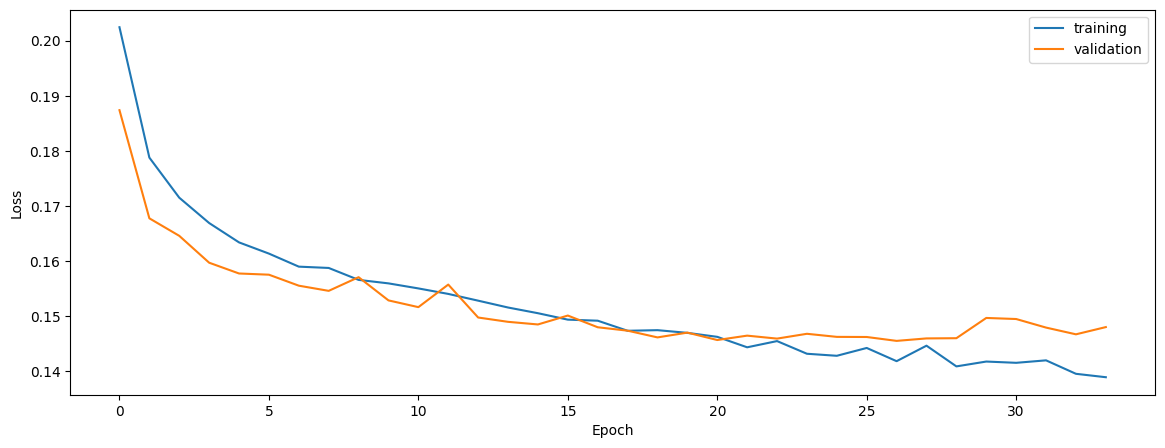

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.669698075899308
0.6636456540447504
0.6345709174992366


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.665874266814811
0.6538673121355485
0.63757816941444


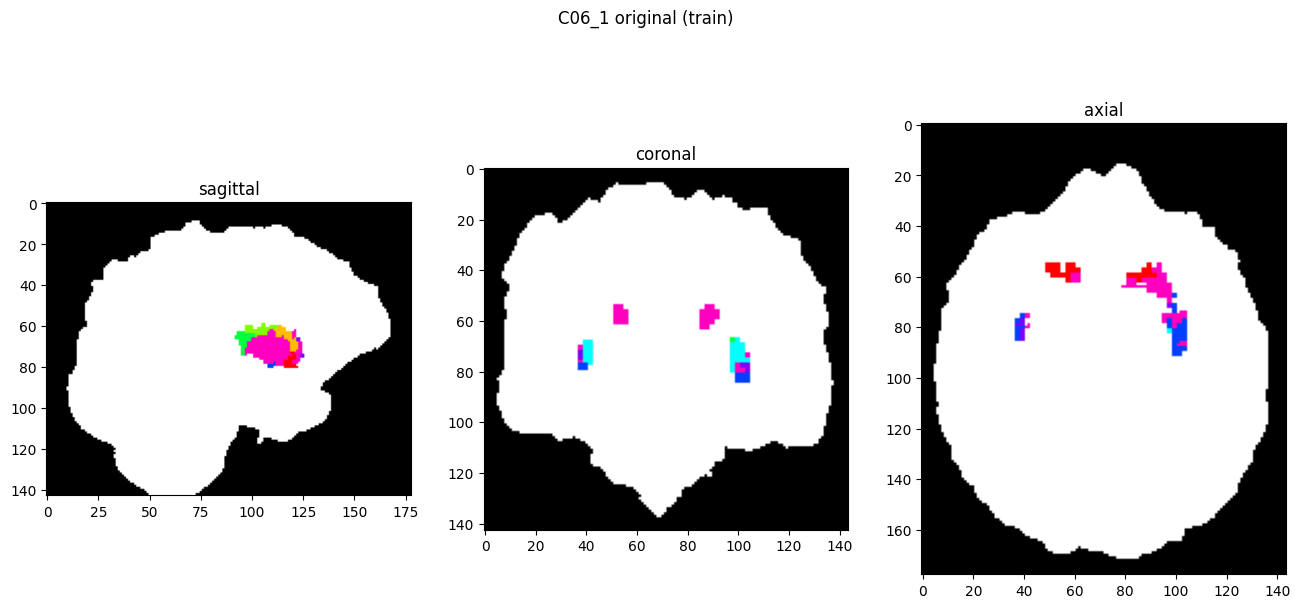

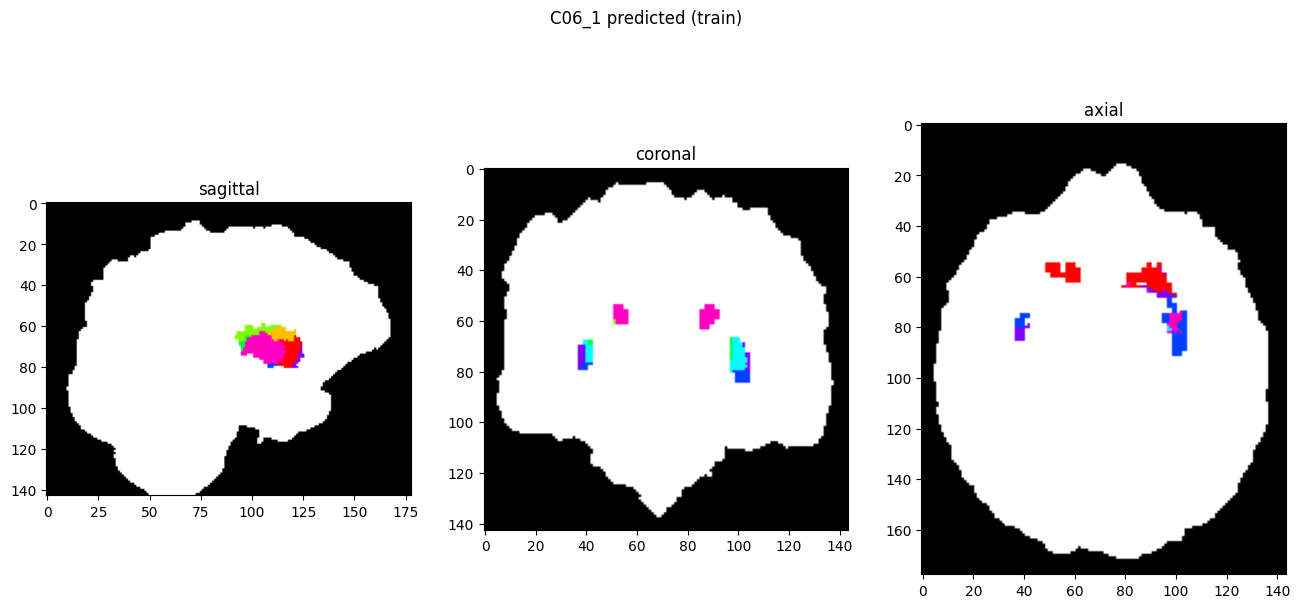

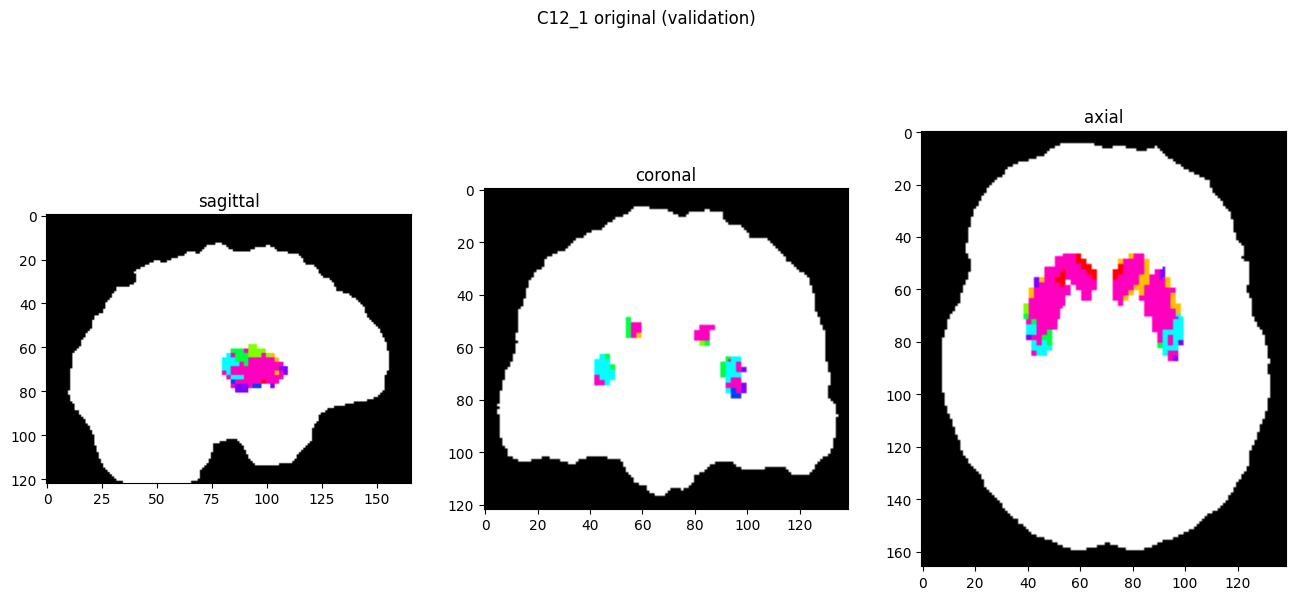

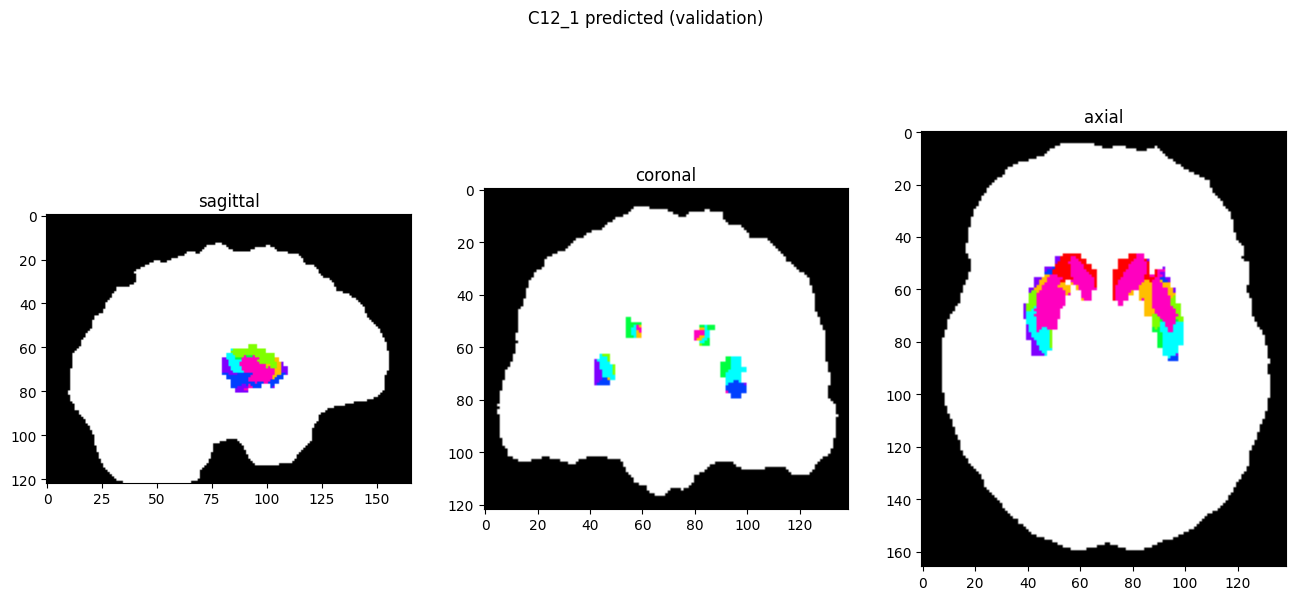

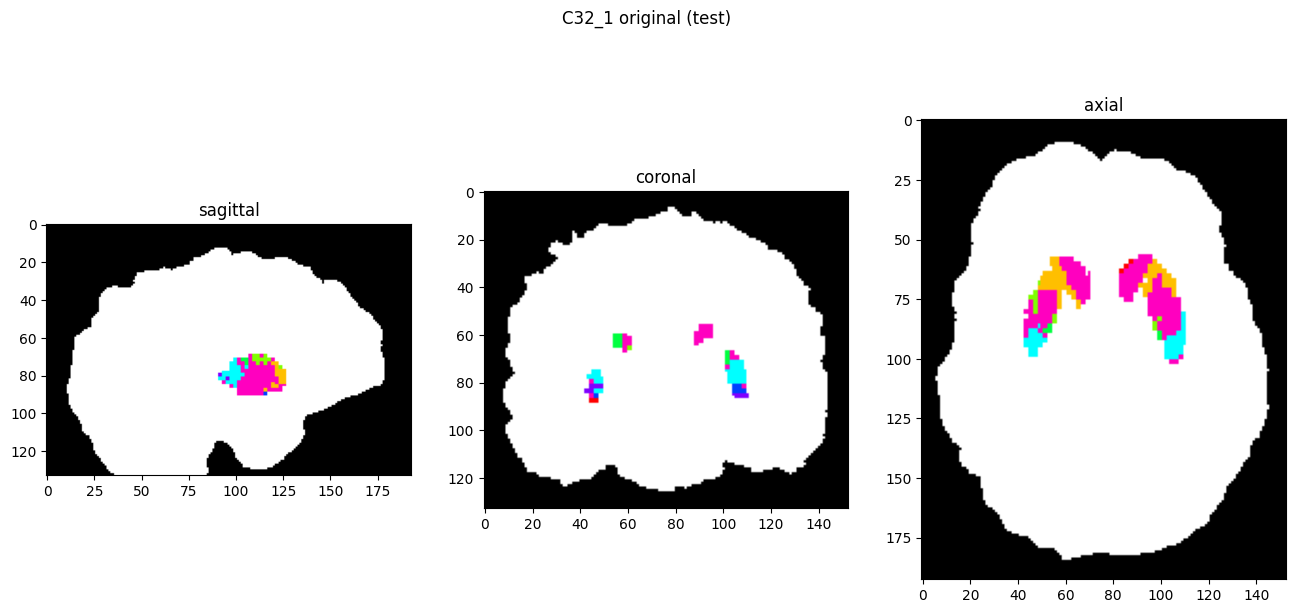

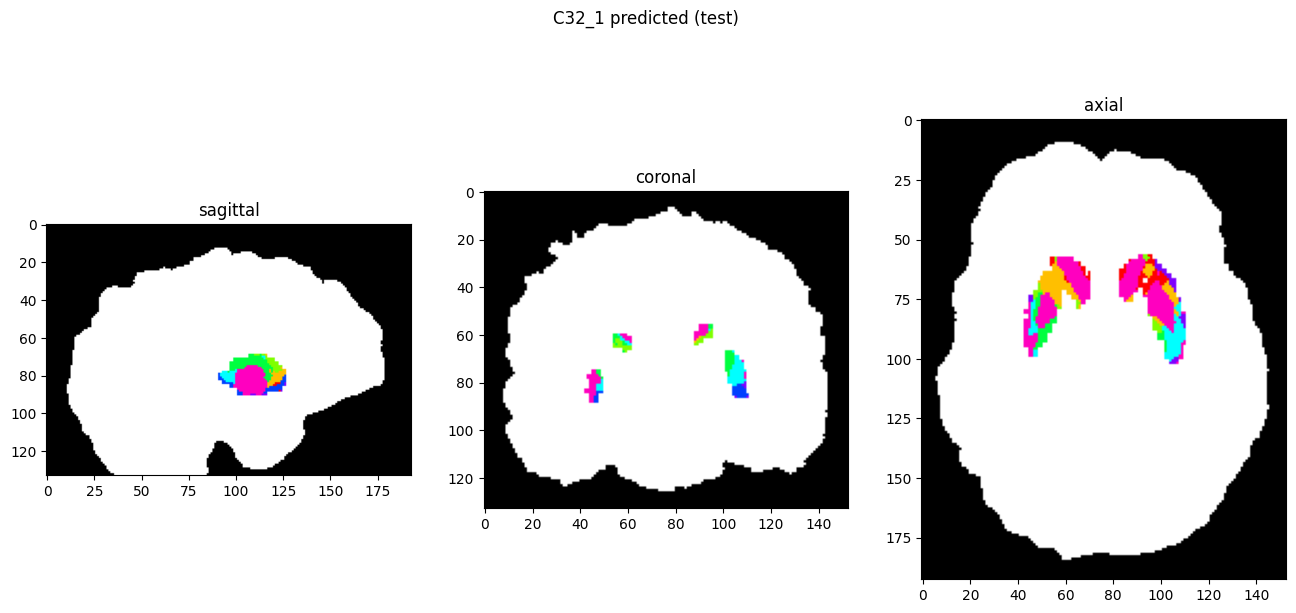

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)